![image](https://user-images.githubusercontent.com/92790663/189541779-82e3ea35-da9c-444d-b5d6-3dfe4456c09c.png)

### BUSINESS PROBLEM

Approximately two million managers play the Fantasy Premier League (FPL) for 38 game weeks every season. Every game week, the big question on the two million minds is which soccer players will provide maximum ROI throughout the season. A predictive analytics model for weekly ROI from a player is crucial information sought by FPL managers. This project investigates a model based on the historical data of players' performance against their opponents.

#### BUSINESS OBJECTIVES
- Create a model that predicts points for each player weekly and evaluate the model's accuracy.
- Predict and select players with high returns on fantasy points before every game week.
- Players comparison using analytics.

#### DATA SOURCES 
[Link 1](https://www.fantasynutmeg.com)

- This source provides historical data from the 2016 season till the current season. The extracted data contains only data of players with double digits fantasy points across every fixture in respective seasons. There is an opportunity to extract every player's performance for every fixture from 2016 to the current season. This is an issue to resolve as part of the optimization phase of this project.


[Link 2](https://fantasy.premierleague.com/api/)

- This source is the official FPL API that only contains the data on players’ performance in the current season, players' positions and all the current season fixtures.


#### PERFORMANCE METRICS
- Accuracy.
- R-Squared ($R^2$) score (Coefficient of determination).
- RMSE (Root Mean Squared Error).

### IMPORT NECESSARY LIBRARIES

In [1]:
import os
import time
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# sklearn
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# statsmodel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.outliers_influence import variance_inflation_factor

### ACCESSING DATA

In [2]:
# Read data.
df_allseasons = pd.read_csv('cleaned_merged_seasons.csv', index_col = 'Unnamed: 0')
df_allseasons.head()

/tmp/ipykernel_172/1029439869.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_allseasons = pd.read_csv('cleaned_merged_seasons.csv', index_col = 'Unnamed: 0')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
# Print all columns.
df_allseasons.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [4]:
# Descriptive information on features.
df_allseasons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           98402 non-null  object 
 1   name               98402 non-null  object 
 2   position           98402 non-null  object 
 3   team_x             48930 non-null  object 
 4   assists            98402 non-null  int64  
 5   bonus              98402 non-null  int64  
 6   bps                98402 non-null  int64  
 7   clean_sheets       98402 non-null  int64  
 8   creativity         98402 non-null  float64
 9   element            98402 non-null  int64  
 10  fixture            98402 non-null  int64  
 11  goals_conceded     98402 non-null  int64  
 12  goals_scored       98402 non-null  int64  
 13  ict_index          98402 non-null  float64
 14  influence          98402 non-null  float64
 15  kickoff_time       98402 non-null  object 
 16  minutes            984

In [5]:
# Check for any missing values.
df_allseasons.isnull().values.any()

True

In [6]:
# Check missing values for each feature.
df_allseasons.isna().sum()

season_x                 0
name                     0
position                 0
team_x               49472
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score            49
team_h_score            49
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
d

In [7]:
# Check for duplicates on each row.
df_allseasons.duplicated().value_counts()

False    98402
dtype: int64

In [8]:
# Check for unique values.
df_allseasons.nunique()

season_x                 6
name                   989
position                 4
team_x                  23
assists                  5
bonus                    4
bps                    113
clean_sheets             2
creativity             860
element                737
fixture                380
goals_conceded          10
goals_scored             5
ict_index              273
influence              528
kickoff_time          1428
minutes                 91
opponent_team           20
opp_team_name           31
own_goals                2
penalties_missed         2
penalties_saved          3
red_cards                2
round                   47
saves                   14
selected             65713
team_a_score             9
team_h_score            10
threat                 149
total_points            31
transfers_balance    32217
transfers_in         24344
transfers_out        26734
value                  100
was_home                 2
yellow_cards             2
GW                      47
d

In [9]:
# Descriptive statistics.
df_allseasons.describe()

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
count,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,9.840200e+04,98353.000000,98353.000000,98402.000000,98402.000000,9.840200e+04,9.840200e+04,9.840200e+04,98402.000000,98402.000000,98402.000000
mean,0.045873,0.122599,6.825359,0.120993,5.352928,311.321701,196.188248,0.542845,0.051279,1.963898,8.169446,36.293561,10.502774,0.001667,0.001098,0.000803,0.002063,20.718309,0.114479,1.988971e+05,1.262097,1.491708,6.127121,1.541798,1.318144e+03,1.395050e+04,1.263175e+04,52.496870,0.057814,20.718309
std,0.227680,0.520794,10.252218,0.326121,11.305636,181.148434,108.663200,0.995002,0.247819,3.218001,13.548566,41.517439,5.768132,0.040791,0.033111,0.028680,0.045373,11.605966,0.688899,4.477919e+05,1.224245,1.310472,14.476371,2.658725,5.859415e+04,5.034220e+04,4.287093e+04,13.123029,0.233392,11.605966
min,0.000000,0.000000,-18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-7.000000,-1.857821e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,103.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,7.122000e+03,0.000000,1.000000,0.000000,0.000000,-1.721000e+03,6.400000e+01,1.850000e+02,45.000000,0.000000,11.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,306.000000,200.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,3.409800e+04,1.000000,1.000000,0.000000,0.000000,-7.800000e+01,5.870000e+02,1.422000e+03,49.000000,0.000000,21.000000
75%,0.000000,0.000000,12.000000,0.000000,3.900000,459.000000,290.000000,1.000000,0.000000,2.900000,12.800000,90.000000,16.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,1.700668e+05,2.000000,2.000000,4.000000,2.000000,1.440000e+02,5.894000e+03,8.614750e+03,55.000000,0.000000,30.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,737.000000,380.000000,9.000000,4.000000,35.800000,163.600000,90.000000,20.000000,1.000000,1.000000,2.000000,1.000000,47.000000,14.000000,6.483921e+06,9.000000,9.000000,186.000000,29.000000,1.983733e+06,2.104464e+06,1.872898e+06,136.000000,1.000000,47.000000


#### Observation
- Some records are missing.
- No duplicate observation.

#### FEATURE ENGINEERING

In [10]:
# Make a copy of the original piece of data.
df_allseasons_clean = df_allseasons.copy()

> To engineer two new features named `club_name` and `form`, we collect data from the `fantasynutmeg` API (Link 1 in the business problem statement), compare the columns of the collected data with the `df_allseasons` dataframe and extract the features highlighted above.

In [11]:
# Get yearly historic data from endpoint for available seasons and identify the keys in each disctionary using 2016 as an example.
Y2016= requests.get('https://www.fantasynutmeg.com/api/history/season/2016-17').json()
Y2017= requests.get('https://www.fantasynutmeg.com/api/history/season/2017-18').json()
Y2018= requests.get('https://www.fantasynutmeg.com/api/history/season/2018-19').json()
Y2019= requests.get('https://www.fantasynutmeg.com/api/history/season/2019-20').json()
Y2020= requests.get('https://www.fantasynutmeg.com/api/history/season/2020-21').json()
Y2021= requests.get('https://www.fantasynutmeg.com/api/history/season/2021-22').json()
Y2022= requests.get('https://www.fantasynutmeg.com/api/history/season/2022-23').json()

Y2016.keys()

dict_keys(['dd_agg_fixture', 'dd_agg_player', 'dd_hauls', 'history'])

In [12]:
# Convert history data dictionary to a pandas dataframe.
hist16_df = pd.DataFrame(Y2016['history'])
hist17_df = pd.DataFrame(Y2017['history'])
hist18_df = pd.DataFrame(Y2018['history'])
hist19_df = pd.DataFrame(Y2019['history'])
hist20_df = pd.DataFrame(Y2020['history'])
hist21_df = pd.DataFrame(Y2021['history'])

In [13]:
# Engineer feature to highlight each season year.
hist16_df['year'] = hist16_df.apply(lambda x: "2016-17", axis=1)
hist17_df['year'] = hist17_df.apply(lambda x: "2017-18", axis=1)
hist18_df['year'] = hist18_df.apply(lambda x: "2018-19", axis=1)
hist19_df['year'] = hist19_df.apply(lambda x: "2019-20", axis=1)
hist20_df['year'] = hist20_df.apply(lambda x: "2020-21", axis=1)
hist21_df['year'] = hist21_df.apply(lambda x: "2021-22", axis=1)

In [14]:
# Concatenate all history data across years.
hist_df = [hist16_df, hist17_df, hist18_df, hist19_df, hist20_df, hist21_df]

hist = pd.concat(hist_df, axis = 0, ignore_index=True)

In [15]:
# Preview history data.
hist.head()

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,dreamteam_count,ea_index,element_type,ep_next,ep_this,event_points,first_name,form,goals_conceded,goals_scored,ict_index,id,in_dreamteam,influence,loaned_in,loaned_out,loans_in,loans_out,minutes,news,now_cost,own_goals,penalties_missed,penalties_saved,photo,points_per_game,position,red_cards,saves,second_name,selected_by_percent,special,squad_number,status,team,team_code,team_name,threat,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards,year,news_added,creativity_rank,creativity_rank_type,ict_index_rank,ict_index_rank_type,influence_rank,influence_rank_type,threat_rank,threat_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0,0,18,100,100,0,48844,0,0,-3,3,0.0,0,56.0,1,0.0,0.0,0,David,0.0,4,0,2.9,1,False,28.8,0.0,0.0,0.0,0.0,143,None,4.7,0,0,0,48844.jpg,1.0,GKP,0,4,Ospina,0.2,False,13,a,1,3,ARS,0.0,2,3433,0,7905,0,0.0,0.4,Ospina,0,2016-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,660,100,100,12,11334,0,0,-1,1,0.1,0,409.0,1,6.0,0.0,4,Petr,0.0,37,0,82.0,2,False,819.8,0.0,0.0,0.0,0.0,3097,None,5.4,1,0,0,11334.jpg,3.8,GKP,0,115,Cech,13.7,False,33,a,1,3,ARS,0.0,134,432837,0,590727,0,0.0,24.8,Cech,2,2016-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,19,723,0,75,10,51507,0,0,1,-1,53.9,3,493.0,2,1.7,0.0,-2,Laurent,0.0,37,2,112.7,3,False,831.2,0.0,0.0,0.0,0.0,2821,Suspended - unknown return date,6.1,0,0,0,51507.jpg,3.7,DEF,1,0,Koscielny,11.2,False,6,s,1,3,ARS,239.0,121,965040,0,857277,0,0.0,19.8,Koscielny,4,2016-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,5,100,100,0,17127,0,0,-2,2,0.1,0,265.0,2,0.0,0.0,1,Per,0.0,1,0,1.8,4,False,17.8,0.0,0.0,0.0,0.0,38,None,4.8,0,0,0,17127.jpg,1.0,DEF,0,0,Mertesacker,0.2,False,4,a,1,3,ARS,0.0,1,2141,0,5912,0,0.0,0.2,Mertesacker,0,2016-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,296,75,100,5,158074,0,0,-2,2,84.5,0,244.0,2,1.0,0.0,0,Gabriel Armando,0.0,18,0,50.0,5,False,295.8,0.0,0.0,0.0,0.0,1517,Knee injury - 75% chance of playing,4.8,0,0,0,158074.jpg,2.4,DEF,0,0,de Abreu,0.8,False,5,d,1,3,ARS,119.0,45,119600,0,100361,0,0.0,9.4,Gabriel,6,2016-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Engineer feature to highlight the form of the players.
hist['form'] = hist['total_points']/38 

In [17]:
# Print all columns.
hist.columns

Index(['assists', 'bonus', 'bps', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'clean_sheets', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'creativity', 'dreamteam_count', 'ea_index',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'goals_conceded', 'goals_scored', 'ict_index', 'id',
       'in_dreamteam', 'influence', 'loaned_in', 'loaned_out', 'loans_in',
       'loans_out', 'minutes', 'news', 'now_cost', 'own_goals',
       'penalties_missed', 'penalties_saved', 'photo', 'points_per_game',
       'position', 'red_cards', 'saves', 'second_name', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team', 'team_code', 'team_name',
       'threat', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'yellow_cards', 'year', 'news_added', 

We have the historical data from 16-21. We proceed as described below:
1. Create a column with the First Name, Last Name and the Year. 
2. Combine the name and the year of the df_`allseasons` dataframe to match the historical data. 
3. Map the two based on the First Name, Last Name and the Year and extract needed features.

In [18]:
# Engineer feature to highlight the players name and the season they played in.
hist['name_season'] = hist['first_name'] + ' ' + hist['second_name'] + '_' + hist['year']

In [19]:
# Display a sample of name_season column.
hist.name_season.head()

0                David Ospina_2016-17
1                   Petr Cech_2016-17
2           Laurent Koscielny_2016-17
3             Per Mertesacker_2016-17
4    Gabriel Armando de Abreu_2016-17
Name: name_season, dtype: object

In [20]:
# Data Quality Checks.
subset  = ['Mohamed Salah_2018-19']
check = hist[hist.name_season.isin(subset)]
check.form

1582    6.815789
Name: form, dtype: float64

In [21]:
# Engineer feature to highlight the players name and the season they played in.
df_allseasons_clean['name_season'] = df_allseasons_clean['name'] + '_' + df_allseasons_clean['season_x']

In [22]:
# Engineer a feature to highlight the club of the player.
teams=dict(zip(hist.name_season, hist.team_name))

df_allseasons_clean['club_name'] = df_allseasons_clean['name_season'].map(teams)

In [23]:
df_allseasons_clean.query('club_name.isna() == True')

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,name_season,club_name
8181,2017-18,David de Gea,GK,NaN,0,0,22,1,0.0,260,9,0,0,1.1,10.6,2017-08-13T15:00:00Z,90,20,West Ham,0,0,0,0,1,1,1195182,0.0,4.0,0.0,6,0,0,0,55,True,0,1,David de Gea_2017-18,NaN
8440,2017-18,David de Gea,GK,NaN,0,2,27,1,0.0,260,98,0,0,2.4,23.6,2017-10-28T11:30:00Z,90,17,Spurs,0,0,0,0,10,4,2057321,0.0,1.0,0.0,9,-7940,40279,48219,56,True,0,10,David de Gea_2017-18,NaN
8712,2017-18,David de Gea,GK,NaN,0,0,24,0,0.0,260,101,1,0,4.7,46.6,2017-11-05T16:30:00Z,90,5,Chelsea,0,0,0,0,11,7,2122417,0.0,1.0,0.0,4,41649,59249,17600,57,False,0,11,David de Gea_2017-18,NaN
8985,2017-18,David de Gea,GK,NaN,0,0,15,0,0.0,260,118,1,0,2.2,22.0,2017-11-18T17:30:00Z,90,13,Newcastle,0,0,0,0,12,4,2234698,1.0,4.0,0.0,3,82813,94321,11508,58,True,0,12,David de Gea_2017-18,NaN
9259,2017-18,David de Gea,GK,NaN,0,0,23,1,0.0,260,124,0,0,1.4,13.8,2017-11-25T15:00:00Z,90,3,Brighton,0,0,0,0,13,2,2264528,0.0,1.0,0.0,6,13584,30805,17221,58,True,0,13,David de Gea_2017-18,NaN
9533,2017-18,David de Gea,GK,NaN,0,0,11,0,0.0,260,133,2,0,1.2,11.6,2017-11-28T20:00:00Z,90,18,Watford,0,0,0,0,14,1,2282900,4.0,2.0,0.0,1,6566,24404,17838,58,False,0,14,David de Gea_2017-18,NaN
9809,2017-18,David de Gea,GK,NaN,0,2,36,0,0.0,260,141,1,0,8.1,80.8,2017-12-02T17:30:00Z,90,1,Arsenal,0,0,0,0,15,14,2258277,3.0,1.0,0.0,8,-35957,12942,48899,58,False,0,15,David de Gea_2017-18,NaN
10086,2017-18,David de Gea,GK,NaN,0,0,18,0,0.0,260,155,2,0,3.9,38.6,2017-12-10T16:30:00Z,90,11,Man City,0,0,0,0,16,5,2296888,2.0,1.0,0.0,2,16178,40389,24211,58,True,0,16,David de Gea_2017-18,NaN
10363,2017-18,David de Gea,GK,NaN,0,3,34,1,0.0,260,164,0,0,4.2,42.4,2017-12-13T20:00:00Z,90,2,Bournemouth,0,0,0,0,17,7,2355583,0.0,1.0,0.0,11,44354,51969,7615,58,True,0,17,David de Gea_2017-18,NaN
10642,2017-18,David de Gea,GK,NaN,0,0,20,0,10.0,260,180,1,0,3.5,24.6,2017-12-17T14:15:00Z,90,19,West Brom,0,0,0,0,18,4,2426184,2.0,1.0,0.0,3,54258,61298,7040,59,False,0,18,David de Gea_2017-18,NaN


All club_names with NaN values are from David De Gea in the 2017-18 season. They will be replaced with the appropriate club_name.

In [24]:
# Update De Gea's missing club name 
df_allseasons_clean['club_name'].fillna('MUN', inplace = True)

In [25]:
# Engineer a feature to highlight the form of the player.
teams=dict(zip(hist.name_season, hist.form))

df_allseasons_clean['form'] = df_allseasons_clean['name_season'].map(teams)

In [26]:
# Preview dataframe.
df_allseasons_clean.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,name_season,club_name,form
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1,Aaron Cresswell_2016-17,WHU,1.578947
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1,Aaron Lennon_2016-17,EVE,0.578947
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1,Aaron Ramsey_2016-17,ARS,1.473684
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1,Abdoulaye Doucouré_2016-17,WAT,1.000000
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1,Adam Forshaw_2016-17,MID,2.026316


In [27]:
# Data Quality Checks.
subset  = ['Marcus Rashford_2020-21']
check = df_allseasons_clean[df_allseasons_clean.name_season.isin(subset)]
check.form

50237    4.578947
50787    4.578947
51344    4.578947
51917    4.578947
52611    4.578947
53207    4.578947
53807    4.578947
54408    4.578947
55010    4.578947
55566    4.578947
56157    4.578947
56764    4.578947
57374    4.578947
57988    4.578947
58498    4.578947
59044    4.578947
59480    4.578947
60327    4.578947
60328    4.578947
61026    4.578947
61674    4.578947
62336    4.578947
63001    4.578947
63780    4.578947
64523    4.578947
65608    4.578947
65609    4.578947
65890    4.578947
66643    4.578947
67606    4.578947
68293    4.578947
68985    4.578947
69666    4.578947
70880    4.578947
70881    4.578947
70882    4.578947
72475    4.578947
73181    4.578947
Name: form, dtype: float64

In [28]:
# Print all columns.
df_allseasons_clean.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name', 'form'],
      dtype='object')

In [29]:
# Engineer feature to highlight the game dates from kickoff_time.
df_allseasons_clean['game_date'] = df_allseasons_clean['kickoff_time'].str.replace('T', ' ')
df_allseasons_clean['game_date'] = df_allseasons_clean['game_date'].str.replace(':00Z', '')

In [30]:
# Preview series.
df_allseasons_clean.game_date.head()

0    2016-08-15 19:00
1    2016-08-13 14:00
2    2016-08-14 15:00
3    2016-08-13 14:00
4    2016-08-13 14:00
Name: game_date, dtype: object

In [31]:
# Convert game_date feature to appropriate dtype.
df_allseasons_clean['game_date'] = pd.to_datetime(df_allseasons_clean['game_date'])

In [32]:
# Preview series.
df_allseasons_clean.game_date.head()

0   2016-08-15 19:00:00
1   2016-08-13 14:00:00
2   2016-08-14 15:00:00
3   2016-08-13 14:00:00
4   2016-08-13 14:00:00
Name: game_date, dtype: datetime64[ns]

In [33]:
# Engineer game season weather feature.
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

month_to_season = dict(zip(range(1,13), seasons))
df_allseasons_clean['game_weather'] = df_allseasons_clean.game_date.dt.month.map(month_to_season) 

In [34]:
# Data Quality Check.
df_allseasons_clean.game_weather.value_counts()

1    36939
2    26810
4    24533
3    10120
Name: game_weather, dtype: int64

In [35]:
# Engineer feature to highlights games that started before 13:00 (early starts) and those that started after 13:00 (late starts)
df_allseasons_clean['start_label'] = np.where((df_allseasons_clean['game_date'].dt.hour) < 13, 0, 1)

In [36]:
# Quality Check.
df_allseasons_clean[['game_date', 'start_label']].head(20)

,game_date,start_label
0,2016-08-15 19:00:00,1
1,2016-08-13 14:00:00,1
2,2016-08-14 15:00:00,1
3,2016-08-13 14:00:00,1
4,2016-08-13 14:00:00,1
5,2016-08-14 15:00:00,1
6,2016-08-15 19:00:00,1
7,2016-08-14 15:00:00,1
8,2016-08-13 14:00:00,1
9,2016-08-14 15:00:00,1


In [37]:
# Descriptive information on all features.
df_allseasons_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   season_x           98402 non-null  object        
 1   name               98402 non-null  object        
 2   position           98402 non-null  object        
 3   team_x             48930 non-null  object        
 4   assists            98402 non-null  int64         
 5   bonus              98402 non-null  int64         
 6   bps                98402 non-null  int64         
 7   clean_sheets       98402 non-null  int64         
 8   creativity         98402 non-null  float64       
 9   element            98402 non-null  int64         
 10  fixture            98402 non-null  int64         
 11  goals_conceded     98402 non-null  int64         
 12  goals_scored       98402 non-null  int64         
 13  ict_index          98402 non-null  float64       
 14  influe

In [38]:
# Check missing values for each feature.
df_allseasons_clean.isna().sum()

season_x                 0
name                     0
position                 0
team_x               49472
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score            49
team_h_score            49
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
n

In [39]:
# Check the Nan values in team_a_score and team_h_score.
filt = df_allseasons_clean['team_a_score'].isna() == True
df_allseasons_clean.loc[filt, 'team_h_score']

44426   NaN
44428   NaN
44430   NaN
44444   NaN
44450   NaN
44453   NaN
44458   NaN
44465   NaN
44485   NaN
44490   NaN
44494   NaN
44498   NaN
44502   NaN
44505   NaN
44510   NaN
44514   NaN
44521   NaN
44535   NaN
44549   NaN
44559   NaN
44572   NaN
44574   NaN
44589   NaN
44602   NaN
44616   NaN
44622   NaN
44624   NaN
44627   NaN
44630   NaN
44656   NaN
44658   NaN
44681   NaN
44691   NaN
44700   NaN
44714   NaN
44728   NaN
44736   NaN
44740   NaN
44761   NaN
44769   NaN
44785   NaN
44807   NaN
44839   NaN
44856   NaN
44866   NaN
44870   NaN
44872   NaN
44902   NaN
44917   NaN
Name: team_h_score, dtype: float64

To engineer 10 new features named `average_squad_age`, `team_strength`, `attack_strength`, `defence_strength`, `home_team_strength`, `away_team_strength`, `home_attack_strength`, `home_defence_strength`, `away_attack_strength` and `away_defence_strength`, we collect data from the fbref API (Link 3 in the business problem statement), compare the columns of the collected data with the df_allseasons dataframe and extract the features highlighted above.

In [40]:
# Scraping overall league table html tags for all the seasons
seasons = ['2021-2022/2021-2022', '2020-2021/2020-2021', '2019-2020/2019-2020', '2018-2019/2018-2019', '2017-2018/2017-2018', '2016-2017/2016-2017']
data = []
i = 0
html_text = []
for season in seasons:
    url = f"https://fbref.com/en/comps/9/{season}-Premier-League-Stats"
    data.append(url)
    html = requests.get(data[i])
    i+=1
    html_text.append(html)

In [41]:
# Extracting respective season league table text from html_text
tables_seasons = ['2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018', '2016-2017']
tables = []
for tags in html_text:
    soup = BeautifulSoup(tags.text)
    id_text = soup.find('table', id=[f"results{table}91_overall" for table in tables_seasons])
    tables.append(id_text)


In [42]:
# Code definition deal with white space in the dataframes
def whitespace_remover(dataframe):
   
    # iterating over the columns
    for i in dataframe.columns:

        # checking datatype of each columns
        if dataframe[i].dtype == 'object':
             
            # applying strip function on column
            dataframe[i] = dataframe[i].map(str.strip)
        else: 
            
            # if condn. is False then it will do nothing.
            pass

In [43]:
# Obtain league table for 2021 season
league_table_2021 = []
for index in tables[0].find_all('td'):
    title = index.text
    league_table_2021.append(title)
    
league_table_2021 = [league_table_2021[i: i+18] for i in range(0, len(league_table_2021), 18)]
league_table_2021 = pd.DataFrame(league_table_2021, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_table_2021.drop(['xG', 'xGA', 'xGD', 'xGD/90'], axis=1, inplace=True)
league_table_2021['year'] = league_table_2021.apply(lambda x: "2021-22", axis=1)

whitespace_remover(league_table_2021)

league_table_2021.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Manchester City,38,29,6,3,99,26,+73,93,2.45,"52,774",Kevin De Bruyne - 15,Ederson,→ Champions League via league finish,1,2021-22
1,Liverpool,38,28,8,2,94,26,+68,92,2.42,"53,352",Mohamed Salah - 23,Alisson,→ Champions League via league finish,2,2021-22
2,Chelsea,38,21,11,6,76,33,+43,74,1.95,"36,443",Mason Mount - 11,Edouard Mendy,→ Champions League via league finish,3,2021-22
3,Tottenham,38,22,5,11,69,40,+29,71,1.87,"56,523",Son Heung-min - 23,Hugo Lloris,→ Champions League via league finish,4,2021-22
4,Arsenal,38,22,3,13,61,48,+13,69,1.82,"59,665",Bukayo Saka - 11,Aaron Ramsdale,→ Europa League via league finish,5,2021-22


In [44]:
# Obtain league table for 2020 season
league_table_2020 = []
for index in tables[1].find_all('td'):
    title = index.text
    league_table_2020.append(title)

league_table_2020 = [league_table_2020[i: i+18] for i in range(0, len(league_table_2020), 18)]
league_table_2020 = pd.DataFrame(league_table_2020, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2020['Rank'] = range(1, 1+len(league_table_2020))
league_table_2020.drop(['xG', 'xGA', 'xGD', 'xGD/90',], axis=1, inplace=True)
league_table_2020['year'] = league_table_2020.apply(lambda x: "2020-21", axis=1)

whitespace_remover(league_table_2020)

league_table_2020.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Manchester City,38,27,5,6,83,32,+51,86,2.26,526,İlkay Gündoğan - 13,Ederson,→ Champions League via league finish,1,2020-21
1,Manchester Utd,38,21,11,6,73,44,+29,74,1.95,526,Bruno Fernandes - 18,David de Gea,→ Champions League via league finish,2,2020-21
2,Liverpool,38,20,9,9,68,42,+26,69,1.82,837,Mohamed Salah - 22,Alisson,→ Champions League via league finish,3,2020-21
3,Chelsea,38,19,10,9,58,36,+22,67,1.76,526,Jorginho - 7,Edouard Mendy,→ Champions League via league finish,4,2020-21
4,Leicester City,38,20,6,12,68,50,+18,66,1.74,421,Jamie Vardy - 15,Kasper Schmeichel,→ Europa League via cup win,5,2020-21


In [45]:
# Obtain league table for 2019 season
league_table_2019 = []
for index in tables[2].find_all('td'):
    title = index.text
    league_table_2019.append(title)

league_table_2019 = [league_table_2019[i: i+18] for i in range(0, len(league_table_2019), 18)]
league_table_2019 = pd.DataFrame(league_table_2019, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2019['Rank'] = range(1, 1+len(league_table_2019))
league_table_2019.drop(['xG', 'xGA', 'xGD', 'xGD/90',], axis=1, inplace=True)
league_table_2019['year'] = league_table_2019.apply(lambda x: "2019-20", axis=1)

whitespace_remover(league_table_2019)

league_table_2019.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Liverpool,38,32,3,3,85,33,+52,99,2.61,"41,955",Mohamed Salah - 19,Alisson,→ Champions League via league finish,1,2019-20
1,Manchester City,38,26,3,9,102,35,+67,81,2.13,"37,097",Raheem Sterling - 20,Ederson,→ Champions League via league finish,2,2019-20
2,Manchester Utd,38,18,12,8,66,36,+30,66,1.74,"57,415","Anthony Martial, Marcus Rashford - 17",David de Gea,→ Champions League via league finish,3,2019-20
3,Chelsea,38,20,6,12,69,54,+15,66,1.74,"32,023",Tammy Abraham - 15,Kepa Arrizabalaga,→ Champions League via league finish,4,2019-20
4,Leicester City,38,18,8,12,67,41,+26,62,1.63,"25,312",Jamie Vardy - 23,Kasper Schmeichel,→ Europa League via league finish,5,2019-20


In [46]:
# Obtain league table for 2018 season
league_table_2018 = []
for index in tables[3].find_all('td'):
    title = index.text
    league_table_2018.append(title)
    
league_table_2018 = [league_table_2018[i: i+18] for i in range(0, len(league_table_2018), 18)]
league_table_2018 = pd.DataFrame(league_table_2018, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2018['Rank'] = range(1, 1+len(league_table_2018))
league_table_2018.drop(['xG', 'xGA', 'xGD', 'xGD/90',], axis=1, inplace=True)
league_table_2018['year'] = league_table_2018.apply(lambda x: "2018-19", axis=1)

whitespace_remover(league_table_2018)

league_table_2018.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Manchester City,38,32,2,4,95,23,+72,98,2.58,"54,130",Sergio Agüero - 21,Ederson,→ Champions League via league finish,1,2018-19
1,Liverpool,38,30,7,1,89,22,+67,97,2.55,"52,983","Sadio Mané, Mohamed Salah - 22",Alisson,→ Champions League via league finish,2,2018-19
2,Chelsea,38,21,9,8,63,39,+24,72,1.89,"40,437",Eden Hazard - 16,Kepa Arrizabalaga,→ Champions League via league finish,3,2018-19
3,Tottenham,38,23,2,13,67,39,+28,71,1.87,"54,216",Harry Kane - 17,Hugo Lloris,→ Champions League via league finish,4,2018-19
4,Arsenal,38,21,7,10,73,51,+22,70,1.84,"59,899",Pierre-Emerick Aubameyang - 22,Bernd Leno,→ Europa League via league finish,5,2018-19


In [47]:
# Obtain league table for 2017 season
league_table_2017 = []
for index in tables[4].find_all('td'):
    title = index.text
    league_table_2017.append(title)
    
league_table_2017 = [league_table_2017[i: i+18] for i in range(0, len(league_table_2017), 18)]
league_table_2017 = pd.DataFrame(league_table_2017, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2017['Rank'] = range(1, 1+len(league_table_2017))
league_table_2017.drop(['xG', 'xGA', 'xGD', 'xGD/90',], axis=1, inplace=True)
league_table_2017['year'] = league_table_2017.apply(lambda x: "2017-18", axis=1)

whitespace_remover(league_table_2017)

league_table_2017.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Manchester City,38,32,4,2,106,27,+79,100,2.63,"54,070",Sergio Agüero - 21,Ederson,→ Champions League via league finish,1,2017-18
1,Manchester Utd,38,25,6,7,68,28,+40,81,2.13,"74,976",Romelu Lukaku - 16,David de Gea,→ Champions League via league finish,2,2017-18
2,Tottenham,38,23,8,7,74,36,+38,77,2.03,"67,953",Harry Kane - 30,Hugo Lloris,→ Champions League via league finish,3,2017-18
3,Liverpool,38,21,12,5,84,38,+46,75,1.97,"53,049",Mohamed Salah - 32,"Loris Karius, Simon Mignolet",→ Champions League via league finish,4,2017-18
4,Chelsea,38,21,7,10,62,38,+24,70,1.84,"41,282",Eden Hazard - 12,Thibaut Courtois,→ Europa League via cup win 1,5,2017-18


In [48]:
# Obtain league table for 2016 season
league_table_2016 = []
for index in tables[5].find_all('td'):
    title = index.text
    league_table_2016.append(title)
    
league_table_2016 = [league_table_2016[i: i+14] for i in range(0, len(league_table_2016), 14)]
league_table_2016 = pd.DataFrame(league_table_2016, columns = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'])
league_table_2016['Rank'] = range(1, 1+len(league_table_2016))
league_table_2016['year'] = league_table_2016.apply(lambda x: "2016-17", axis=1)

whitespace_remover(league_table_2016)

league_table_2016.head()

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year
0,Chelsea,38,30,3,5,85,33,+52,93,2.45,"41,508",Diego Costa - 20,Thibaut Courtois,→ Champions League via league finish,1,2016-17
1,Tottenham,38,26,8,4,86,26,+60,86,2.26,"31,639",Harry Kane - 29,Hugo Lloris,→ Champions League via league finish,2,2016-17
2,Manchester City,38,23,9,6,80,39,+41,78,2.05,"54,019",Sergio Agüero - 20,Claudio Bravo,→ Champions League via league finish,3,2016-17
3,Liverpool,38,22,10,6,78,42,+36,76,2.00,"53,016","Philippe Coutinho, Sadio Mané - 13",Simon Mignolet,→ Champions League via league finish,4,2016-17
4,Arsenal,38,23,6,9,77,44,+33,75,1.97,"59,957",Alexis Sánchez - 24,Petr Čech,→ Europa League via cup win 1,5,2016-17


In [49]:
# Extracting home and away season league table text from html_text
tables_home_away = ['2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018', '2016-2017']
tables_hw = []
for tags in html_text:
    soup = BeautifulSoup(tags.text)
    id_text = soup.find('table', id=[f"results{table}91_home_away" for table in tables_home_away])
    tables_hw.append(id_text)

In [50]:
# Obtain home and away table for 2021
league_home_away_2021 = []
for index in tables_hw[0].find_all('td'):
    title = index.text
    league_home_away_2021.append(title)
    
league_home_away_2021
league_home_away_2021 = [league_home_away_2021[i: i+27] for i in range(0, len(league_home_away_2021), 27)]
league_home_away_2021 = pd.DataFrame(league_home_away_2021, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'])
league_home_away_2021.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2021['year'] = league_home_away_2021.apply(lambda x: "2021-22", axis=1)

whitespace_remover(league_home_away_2021)

league_home_away_2021.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Manchester City,19,15,2,2,58,15,+43,47,2.47,19,14,4,1,41,11,+30,46,2.42,2021-22
1,Liverpool,19,15,4,0,49,9,+40,49,2.58,19,13,4,2,45,17,+28,43,2.26,2021-22
2,Chelsea,19,9,7,3,37,22,+15,34,1.79,19,12,4,3,39,11,+28,40,2.11,2021-22
3,Tottenham,19,13,1,5,38,19,+19,40,2.11,19,9,4,6,31,21,+10,31,1.63,2021-22
4,Arsenal,19,13,2,4,35,17,+18,41,2.16,19,9,1,9,26,31,-5,28,1.47,2021-22


In [51]:
# Obtain home and away table for 2020
league_home_away_2020 = []
for index in tables_hw[1].find_all('td'):
    title = index.text
    league_home_away_2020.append(title)
    
league_home_away_2020
league_home_away_2020 = [league_home_away_2020[i: i+27] for i in range(0, len(league_home_away_2020), 27)]
league_home_away_2020 = pd.DataFrame(league_home_away_2020, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'])
league_home_away_2020.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2020['year'] = league_home_away_2020.apply(lambda x: "2020-21", axis=1)

whitespace_remover(league_home_away_2020)

league_home_away_2020.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Manchester City,19,13,2,4,43,17,+26,41,2.16,19,14,3,2,40,15,+25,45,2.37,2020-21
1,Manchester Utd,19,9,4,6,38,28,+10,31,1.63,19,12,7,0,35,16,+19,43,2.26,2020-21
2,Liverpool,19,10,3,6,29,20,+9,33,1.74,19,10,6,3,39,22,+17,36,1.89,2020-21
3,Chelsea,19,9,6,4,31,18,+13,33,1.74,19,10,4,5,27,18,+9,34,1.79,2020-21
4,Leicester City,19,9,1,9,34,30,+4,28,1.47,19,11,5,3,34,20,+14,38,2.00,2020-21


In [52]:
# Obtain home and away table for 2019
league_home_away_2019 = []
for index in tables_hw[2].find_all('td'):
    title = index.text
    league_home_away_2019.append(title)
    
league_home_away_2019
league_home_away_2019 = [league_home_away_2019[i: i+27] for i in range(0, len(league_home_away_2019), 27)]
league_home_away_2019 = pd.DataFrame(league_home_away_2019, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'])
league_home_away_2019.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2019['year'] = league_home_away_2019.apply(lambda x: "2019-20", axis=1)

whitespace_remover(league_home_away_2019)

league_home_away_2019.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Liverpool,19,18,1,0,52,16,+36,55,2.89,19,14,2,3,33,17,+16,44,2.32,2019-20
1,Manchester City,19,15,2,2,57,13,+44,47,2.47,19,11,1,7,45,22,+23,34,1.79,2019-20
2,Manchester Utd,19,10,7,2,40,17,+23,37,1.95,19,8,5,6,26,19,+7,29,1.53,2019-20
3,Chelsea,19,11,3,5,30,16,+14,36,1.89,19,9,3,7,39,38,+1,30,1.58,2019-20
4,Leicester City,19,11,4,4,35,17,+18,37,1.95,19,7,4,8,32,24,+8,25,1.32,2019-20


In [53]:
# Obtain home and away table for 2018
league_home_away_2018 = []
for index in tables_hw[3].find_all('td'):
    title = index.text
    league_home_away_2018.append(title)
    
league_home_away_2018
league_home_away_2018 = [league_home_away_2018[i: i+27] for i in range(0, len(league_home_away_2018), 27)]
league_home_away_2018 = pd.DataFrame(league_home_away_2018, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'])
league_home_away_2018.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2018['year'] = league_home_away_2018.apply(lambda x: "2018-19", axis=1)

whitespace_remover(league_home_away_2018)

league_home_away_2018.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Manchester City,19,18,0,1,57,12,+45,54,2.84,19,14,2,3,38,11,+27,44,2.32,2018-19
1,Liverpool,19,17,2,0,55,10,+45,53,2.79,19,13,5,1,34,12,+22,44,2.32,2018-19
2,Chelsea,19,12,6,1,39,12,+27,42,2.21,19,9,3,7,24,27,-3,30,1.58,2018-19
3,Tottenham,19,12,2,5,34,16,+18,38,2.00,19,11,0,8,33,23,+10,33,1.74,2018-19
4,Arsenal,19,14,3,2,42,16,+26,45,2.37,19,7,4,8,31,35,-4,25,1.32,2018-19


In [54]:
# Obtain home and away table for 2017
league_home_away_2017 = []
for index in tables_hw[4].find_all('td'):
    title = index.text
    league_home_away_2017.append(title)
    
league_home_away_2017
league_home_away_2017 = [league_home_away_2017[i: i+27] for i in range(0, len(league_home_away_2017), 27)]
league_home_away_2017 = pd.DataFrame(league_home_away_2017, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'])
league_home_away_2017.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2017['year'] = league_home_away_2017.apply(lambda x: "2017-18", axis=1)

whitespace_remover(league_home_away_2017)

league_home_away_2017.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Manchester City,19,16,2,1,61,14,+47,50,2.63,19,16,2,1,45,13,+32,50,2.63,2017-18
1,Manchester Utd,19,15,2,2,38,9,+29,47,2.47,19,10,4,5,30,19,+11,34,1.79,2017-18
2,Tottenham,19,13,4,2,40,16,+24,43,2.26,19,10,4,5,34,20,+14,34,1.79,2017-18
3,Liverpool,19,12,7,0,45,10,+35,43,2.26,19,9,5,5,39,28,+11,32,1.68,2017-18
4,Chelsea,19,11,4,4,30,16,+14,37,1.95,19,10,3,6,32,22,+10,33,1.74,2017-18


In [55]:
# Obtain home and away table for 2016
league_home_away_2016 = []
for index in tables_hw[5].find_all('td'):
    title = index.text
    league_home_away_2016.append(title)
league_home_away_2016
league_home_away_2016 = [league_home_away_2016[i: i+19] for i in range(0, len(league_home_away_2016), 19)]
league_home_away_2016 = pd.DataFrame(league_home_away_2016, columns = ['Squad', 'H_MP', 'H_W', 'H_D', 'H_L', 'H_GF', 'H_GA', 'H_GD', 'H_Pts', 'H_Pts/MP', 'A_MP', 'A_W', 'A_D', 'A_L', 'A_GF', 'A_GA', 'A_GD', 'A_Pts', 'A_Pts/MP'])
#league_home_away_2016.drop(['H_xG', 'H_xGA', 'H_xGD', 'H_xGD/90', 'A_xG', 'A_xGA', 'A_xGD', 'A_xGD/90'], axis=1, inplace=True)
#league_table_2021['Rank'] = range(1, 1+len(league_table_2021))
league_home_away_2016['year'] = league_home_away_2016.apply(lambda x: "2016-17", axis=1)

whitespace_remover(league_home_away_2016)

league_home_away_2016.head()

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year
0,Chelsea,19,17,0,2,55,17,+38,51,2.68,19,13,3,3,30,16,+14,42,2.21,2016-17
1,Tottenham,19,17,2,0,47,9,+38,53,2.79,19,9,6,4,39,17,+22,33,1.74,2016-17
2,Manchester City,19,11,7,1,37,17,+20,40,2.11,19,12,2,5,43,22,+21,38,2.00,2016-17
3,Liverpool,19,12,5,2,45,18,+27,41,2.16,19,10,5,4,33,24,+9,35,1.84,2016-17
4,Arsenal,19,14,3,2,39,16,+23,45,2.37,19,9,3,7,38,28,+10,30,1.58,2016-17


In [56]:
# Convert Attendance feature to numeric datatype
league_table_2016['Attendance'] = pd.to_numeric(league_table_2016['Attendance'].str.replace(',', ''))
league_table_2017['Attendance'] = pd.to_numeric(league_table_2017['Attendance'].str.replace(',', ''))
league_table_2018['Attendance'] = pd.to_numeric(league_table_2018['Attendance'].str.replace(',', ''))
league_table_2019['Attendance'] = pd.to_numeric(league_table_2019['Attendance'].str.replace(',', ''))
league_table_2021['Attendance'] = pd.to_numeric(league_table_2021['Attendance'].str.replace(',', ''))

In [57]:
# Changing erroneus datatype
convert_dict = {'MP': int, 'W': int, 'D': int, 'L': int, 'GF': int, 'GA': int, 'GD': int, 'Pts': int, 'Pts/MP': float}
convert_dict1 = {'H_MP': int, 'H_W': int, 'H_D': int, 'H_L': int, 'H_GF': int, 'H_GA': int, 'H_GD': int, 'H_Pts': int, 'H_Pts/MP': float, 'A_MP': int, 'A_W': int, 'A_D': int, 'A_L': int, 'A_GF': int, 'A_GA': int, 'A_GD': int, 'A_Pts': int, 'A_Pts/MP': float}

league_table_2016 = league_table_2016.astype(convert_dict) 
league_table_2017 = league_table_2017.astype(convert_dict) 
league_table_2018 = league_table_2018.astype(convert_dict)
league_table_2019 = league_table_2019.astype(convert_dict)
league_table_2020 = league_table_2020.astype(convert_dict) 
league_table_2021 = league_table_2021.astype(convert_dict) 

league_home_away_2016 = league_home_away_2016.astype(convert_dict1)
league_home_away_2017 = league_home_away_2017.astype(convert_dict1)
league_home_away_2018 = league_home_away_2018.astype(convert_dict1)
league_home_away_2019 = league_home_away_2019.astype(convert_dict1)
league_home_away_2020 = league_home_away_2020.astype(convert_dict1) 
league_home_away_2021 = league_home_away_2021.astype(convert_dict1) 

In [58]:
# Quality check
league_home_away_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Squad     20 non-null     object 
 1   H_MP      20 non-null     int64  
 2   H_W       20 non-null     int64  
 3   H_D       20 non-null     int64  
 4   H_L       20 non-null     int64  
 5   H_GF      20 non-null     int64  
 6   H_GA      20 non-null     int64  
 7   H_GD      20 non-null     int64  
 8   H_Pts     20 non-null     int64  
 9   H_Pts/MP  20 non-null     float64
 10  A_MP      20 non-null     int64  
 11  A_W       20 non-null     int64  
 12  A_D       20 non-null     int64  
 13  A_L       20 non-null     int64  
 14  A_GF      20 non-null     int64  
 15  A_GA      20 non-null     int64  
 16  A_GD      20 non-null     int64  
 17  A_Pts     20 non-null     int64  
 18  A_Pts/MP  20 non-null     float64
 19  year      20 non-null     object 
dtypes: float64(2), int64(16), object(2

In [59]:
# Function to compute overall team strength, attack strength and defence strength
def calc_team_strength(players):
    players['team_strength'] = 1000
    players['team_strength'] += (players['W'] / players['MP'])*100
    players['team_strength'] -= (players['D'] / players['MP'])*100
    players['team_strength'] -= (players['L'] / players['MP'])*100
    players['attack_strength'] = 1000 
    players['attack_strength'] += (players['GF'] / players['MP'])*100
    players['defence_strength'] = 1000 
    players['defence_strength'] -= (players['GA'] / players['MP'])*100
    return players

In [60]:
league_table_2016 = calc_team_strength(league_table_2016)
league_table_2017 = calc_team_strength(league_table_2017)
league_table_2018 = calc_team_strength(league_table_2018)
league_table_2019 = calc_team_strength(league_table_2019)
league_table_2020 = calc_team_strength(league_table_2020)
league_table_2021 = calc_team_strength(league_table_2021)

league_table_2021.head(20)

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,Rank,year,team_strength,attack_strength,defence_strength
0,Manchester City,38,29,6,3,99,26,73,93,2.45,52774,Kevin De Bruyne - 15,Ederson,→ Champions League via league finish,1,2021-22,1052.631579,1260.526316,931.578947
1,Liverpool,38,28,8,2,94,26,68,92,2.42,53352,Mohamed Salah - 23,Alisson,→ Champions League via league finish,2,2021-22,1047.368421,1247.368421,931.578947
2,Chelsea,38,21,11,6,76,33,43,74,1.95,36443,Mason Mount - 11,Edouard Mendy,→ Champions League via league finish,3,2021-22,1010.526316,1200.000000,913.157895
3,Tottenham,38,22,5,11,69,40,29,71,1.87,56523,Son Heung-min - 23,Hugo Lloris,→ Champions League via league finish,4,2021-22,1015.789474,1181.578947,894.736842
4,Arsenal,38,22,3,13,61,48,13,69,1.82,59665,Bukayo Saka - 11,Aaron Ramsdale,→ Europa League via league finish,5,2021-22,1015.789474,1160.526316,873.684211
5,Manchester Utd,38,16,10,12,57,57,0,58,1.53,73150,Cristiano Ronaldo - 18,David de Gea,→ Europa League via league finish,6,2021-22,984.210526,1150.000000,850.000000
6,West Ham,38,16,8,14,60,51,9,56,1.47,58370,Jarrod Bowen - 12,Łukasz Fabiański,→ Europa Conference League via league finish,7,2021-22,984.210526,1157.894737,865.789474
7,Leicester City,38,14,10,14,62,59,3,52,1.37,32493,Jamie Vardy - 15,Kasper Schmeichel,,8,2021-22,973.684211,1163.157895,844.736842
8,Brighton,38,12,15,11,42,44,-2,51,1.34,30966,"Leandro Trossard, Neal Maupay - 8",Robert Sánchez,,9,2021-22,963.157895,1110.526316,884.210526
9,Wolves,38,15,6,17,38,43,-5,51,1.34,30841,Raúl Jiménez - 6,José Sá,,10,2021-22,978.947368,1100.000000,886.842105


In [61]:
# Function to compute home and away overall strength, attack strength and defence strength
def calc_hw_team_strength(players):
    players['home_team_strength'] = 1000
    players['home_team_strength'] += (players['H_W'] / players['H_MP'])*100
    players['home_team_strength'] -= (players['H_D'] / players['H_MP'])*100
    players['home_team_strength'] -= (players['H_L'] / players['H_MP'])*100
    players['away_team_strength'] = 1000
    players['away_team_strength'] += (players['A_W'] / players['A_MP'])*100
    players['away_team_strength'] -= (players['A_D'] / players['A_MP'])*100
    players['away_team_strength'] -= (players['A_L'] / players['A_MP'])*100
    players['home_attack_strength'] = 1000 
    players['home_attack_strength'] += (players['H_GF'] / players['H_MP'])*100
    players['home_defence_strength'] = 1000 
    players['home_defence_strength'] -= (players['H_GA'] / players['H_MP'])*100
    players['away_attack_strength'] = 1000 
    players['away_attack_strength'] += (players['A_GF'] / players['A_MP'])*100
    players['away_defence_strength'] = 1000 
    players['away_defence_strength'] -= (players['A_GA'] / players['A_MP'])*100
    return players

In [62]:
league_home_away_2016 = calc_hw_team_strength(league_home_away_2016)
league_home_away_2017 = calc_hw_team_strength(league_home_away_2017)
league_home_away_2018 = calc_hw_team_strength(league_home_away_2018)
league_home_away_2019 = calc_hw_team_strength(league_home_away_2019)
league_home_away_2020 = calc_hw_team_strength(league_home_away_2020)
league_home_away_2021 = calc_hw_team_strength(league_home_away_2021)

league_home_away_2021.head(20)

,Squad,H_MP,H_W,H_D,H_L,H_GF,H_GA,H_GD,H_Pts,H_Pts/MP,A_MP,A_W,A_D,A_L,A_GF,A_GA,A_GD,A_Pts,A_Pts/MP,year,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength
0,Manchester City,19,15,2,2,58,15,43,47,2.47,19,14,4,1,41,11,30,46,2.42,2021-22,1057.894737,1047.368421,1305.263158,921.052632,1215.789474,942.105263
1,Liverpool,19,15,4,0,49,9,40,49,2.58,19,13,4,2,45,17,28,43,2.26,2021-22,1057.894737,1036.842105,1257.894737,952.631579,1236.842105,910.526316
2,Chelsea,19,9,7,3,37,22,15,34,1.79,19,12,4,3,39,11,28,40,2.11,2021-22,994.736842,1026.315789,1194.736842,884.210526,1205.263158,942.105263
3,Tottenham,19,13,1,5,38,19,19,40,2.11,19,9,4,6,31,21,10,31,1.63,2021-22,1036.842105,994.736842,1200.000000,900.000000,1163.157895,889.473684
4,Arsenal,19,13,2,4,35,17,18,41,2.16,19,9,1,9,26,31,-5,28,1.47,2021-22,1036.842105,994.736842,1184.210526,910.526316,1136.842105,836.842105
5,Manchester Utd,19,10,5,4,32,22,10,35,1.84,19,6,5,8,25,35,-10,23,1.21,2021-22,1005.263158,963.157895,1168.421053,884.210526,1131.578947,815.789474
6,West Ham,19,9,5,5,33,26,7,32,1.68,19,7,3,9,27,25,2,24,1.26,2021-22,994.736842,973.684211,1173.684211,863.157895,1142.105263,868.421053
7,Leicester City,19,10,4,5,34,23,11,34,1.79,19,4,6,9,28,36,-8,18,0.95,2021-22,1005.263158,942.105263,1178.947368,878.947368,1147.368421,810.526316
8,Brighton,19,5,7,7,19,23,-4,22,1.16,19,7,8,4,23,21,2,29,1.53,2021-22,952.631579,973.684211,1100.000000,878.947368,1121.052632,889.473684
9,Wolves,19,7,3,9,20,25,-5,24,1.26,19,8,3,8,18,18,0,27,1.42,2021-22,973.684211,984.210526,1105.263158,868.421053,1094.736842,905.263158


#### Extract Squad Information

In [63]:
# Extracting respective season squad stats text from html_text
tables_squads = []
for tags in html_text:
    soup = BeautifulSoup(tags.text)
    table_squad = soup.find('table', id='stats_squads_standard_for')
    #id_text = soup.find('div', id=[f"all_results{table}91" for table in tables_seasons])
    tables_squads.append(table_squad)

In [64]:
# Extracting Squad stats such as age, possession, players used from html_text for 2021
stats_squad_2021 = []
for index in tables_squads[0].find_all('td'):
    title = index.text
    stats_squad_2021.append(title)

stats_squad_2021 = [stats_squad_2021[i: i+28] for i in range(0, len(stats_squad_2021), 28)]
stats_squad_2021
stats_squad_2021 = pd.DataFrame(stats_squad_2021, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'])
stats_squad_2021.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2021['year'] = stats_squad_2021.apply(lambda x: "2021-22", axis=1)

stats_squad_2021.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,27,24.4,53.2,38,418,"3,420",38.0,60,41,55,5,8,67,4,1.58,1.08,2.66,1.45,2.53,2021-22
1,31,26.1,46.5,38,418,"3,420",38.0,50,42,47,3,3,81,2,1.32,1.11,2.42,1.24,2.34,2021-22
2,29,25.4,44.5,38,418,"3,420",38.0,46,33,40,6,6,65,3,1.21,0.87,2.08,1.05,1.92,2021-22
3,26,26.2,54.7,38,418,"3,420",38.0,40,30,36,4,7,72,2,1.05,0.79,1.84,0.95,1.74,2021-22
4,23,28.5,39.8,38,418,"3,420",38.0,32,26,31,1,2,68,2,0.84,0.68,1.53,0.82,1.50,2021-22


In [65]:
# Create Squad column in the stats_squad data frame
teams_2021 = ['Arsenal', 'Aston Villa', 'Brentford', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leeds United', 
'Leicester City', 'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Norwich City', 'Southampton', 'Tottenham', 
'Watford', 'West Ham', 'Wolves']

stats_squad_2021['Squad'] = pd.DataFrame(teams_2021, columns = ['Squad'])

stats_squad_2021.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,27,24.4,53.2,38,418,"3,420",38.0,60,41,55,5,8,67,4,1.58,1.08,2.66,1.45,2.53,2021-22,Arsenal
1,31,26.1,46.5,38,418,"3,420",38.0,50,42,47,3,3,81,2,1.32,1.11,2.42,1.24,2.34,2021-22,Aston Villa
2,29,25.4,44.5,38,418,"3,420",38.0,46,33,40,6,6,65,3,1.21,0.87,2.08,1.05,1.92,2021-22,Brentford
3,26,26.2,54.7,38,418,"3,420",38.0,40,30,36,4,7,72,2,1.05,0.79,1.84,0.95,1.74,2021-22,Brighton
4,23,28.5,39.8,38,418,"3,420",38.0,32,26,31,1,2,68,2,0.84,0.68,1.53,0.82,1.50,2021-22,Burnley


In [66]:
# Extracting Squad stats such as age, possession, players used from html_text for 2020
stats_squad_2020 = []
for index in tables_squads[1].find_all('td'):
    title = index.text
    stats_squad_2020.append(title)

stats_squad_2020 = [stats_squad_2020[i: i+28] for i in range(0, len(stats_squad_2020), 28)]
stats_squad_2020
stats_squad_2020 = pd.DataFrame(stats_squad_2020, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'])
stats_squad_2020.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2020['year'] = stats_squad_2020.apply(lambda x: "2020-21", axis=1)

stats_squad_2020.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,29,25.9,53.8,38,418,"3,420",38.0,53,38,47,6,6,49,5,1.39,1.00,2.39,1.24,2.24,2020-21
1,24,25.2,48.1,38,418,"3,420",38.0,52,38,47,5,6,71,4,1.37,1.00,2.37,1.24,2.24,2020-21
2,27,25.8,51.3,38,418,"3,420",38.0,39,24,33,6,9,49,6,1.03,0.63,1.66,0.87,1.50,2020-21
3,25,28.3,41.7,38,418,"3,420",38.0,32,20,29,3,3,48,0,0.84,0.53,1.37,0.76,1.29,2020-21
4,27,26.0,61.4,38,418,"3,420",38.0,56,38,48,8,10,51,3,1.47,1.00,2.47,1.26,2.26,2020-21


In [67]:
# Create Squad column in the stats_squad data frame
teams_2020 = ['Arsenal', 'Aston Villa', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds United', 
'Leicester City', 'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Sheffield United', 'Southampton', 'Tottenham', 
'West Brom', 'West Ham', 'Wolves']

stats_squad_2020['Squad'] = pd.DataFrame(teams_2020, columns = ['Squad'])

stats_squad_2020.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,29,25.9,53.8,38,418,"3,420",38.0,53,38,47,6,6,49,5,1.39,1.00,2.39,1.24,2.24,2020-21,Arsenal
1,24,25.2,48.1,38,418,"3,420",38.0,52,38,47,5,6,71,4,1.37,1.00,2.37,1.24,2.24,2020-21,Aston Villa
2,27,25.8,51.3,38,418,"3,420",38.0,39,24,33,6,9,49,6,1.03,0.63,1.66,0.87,1.50,2020-21,Brighton
3,25,28.3,41.7,38,418,"3,420",38.0,32,20,29,3,3,48,0,0.84,0.53,1.37,0.76,1.29,2020-21,Burnley
4,27,26.0,61.4,38,418,"3,420",38.0,56,38,48,8,10,51,3,1.47,1.00,2.47,1.26,2.26,2020-21,Chelsea


In [68]:
# Extracting Squad stats such as age, possession, players used from html_text for 2019
stats_squad_2019 = []
for index in tables_squads[2].find_all('td'):
    title = index.text
    stats_squad_2019.append(title) 

stats_squad_2019 = [stats_squad_2019[i: i+28] for i in range(0, len(stats_squad_2019), 28)]
stats_squad_2019
stats_squad_2019 = pd.DataFrame(stats_squad_2019, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'])
stats_squad_2019.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2019['year'] = stats_squad_2019.apply(lambda x: "2019-20", axis=1)

stats_squad_2019.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,29,25.8,54.0,38,418,"3,420",38.0,56,35,53,3,3,88,5,1.47,0.92,2.39,1.39,2.32,2019-20
1,28,25.7,43.9,38,418,"3,420",38.0,40,32,39,1,3,70,1,1.05,0.84,1.89,1.03,1.87,2019-20
2,27,25.2,43.8,38,418,"3,420",38.0,38,24,34,4,4,78,3,1.00,0.63,1.63,0.89,1.53,2019-20
3,25,26.4,52.2,38,418,"3,420",38.0,35,24,34,1,2,59,2,0.92,0.63,1.55,0.89,1.53,2019-20
4,22,28.0,41.4,38,418,"3,420",38.0,41,30,38,3,3,67,0,1.08,0.79,1.87,1.00,1.79,2019-20


In [69]:
# Create Squad column in the stats_squad data frame
teams_2019 = ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leicester City', 
'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Norwich City', 'Sheffield United', 'Southampton', 'Tottenham', 
'Watford', 'West Ham', 'Wolves']

stats_squad_2019['Squad'] = pd.DataFrame(teams_2019, columns = ['Squad'])

stats_squad_2019.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,29,25.8,54.0,38,418,"3,420",38.0,56,35,53,3,3,88,5,1.47,0.92,2.39,1.39,2.32,2019-20,Arsenal
1,28,25.7,43.9,38,418,"3,420",38.0,40,32,39,1,3,70,1,1.05,0.84,1.89,1.03,1.87,2019-20,Aston Villa
2,27,25.2,43.8,38,418,"3,420",38.0,38,24,34,4,4,78,3,1.00,0.63,1.63,0.89,1.53,2019-20,Bournemouth
3,25,26.4,52.2,38,418,"3,420",38.0,35,24,34,1,2,59,2,0.92,0.63,1.55,0.89,1.53,2019-20,Brighton
4,22,28.0,41.4,38,418,"3,420",38.0,41,30,38,3,3,67,0,1.08,0.79,1.87,1.00,1.79,2019-20,Burnley


In [70]:
# Extracting Squad stats such as age, possession, players used from html_text for 2018
stats_squad_2018 = []
for index in tables_squads[3].find_all('td'):
    title = index.text
    stats_squad_2018.append(title)

stats_squad_2018 = [stats_squad_2018[i: i+28] for i in range(0, len(stats_squad_2018), 28)]
stats_squad_2018
stats_squad_2018 = pd.DataFrame(stats_squad_2018, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'])
stats_squad_2018.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2018['year'] = stats_squad_2018.apply(lambda x: "2018-19", axis=1)

stats_squad_2018.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,28,26.7,58.0,38,418,"3,420",38.0,69,52,65,4,5,73,2,1.82,1.37,3.18,1.71,3.08,2018-19
1,28,26.6,46.8,38,418,"3,420",38.0,55,43,48,7,9,60,1,1.45,1.13,2.58,1.26,2.39,2018-19
2,21,27.4,42.6,38,418,"3,420",38.0,35,24,30,5,6,61,4,0.92,0.63,1.55,0.79,1.42,2018-19
3,23,28.0,41.2,38,418,"3,420",38.0,43,32,41,2,2,75,1,1.13,0.84,1.97,1.08,1.92,2018-19
4,25,27.7,35.6,38,418,"3,420",38.0,33,20,30,3,4,66,1,0.87,0.53,1.39,0.79,1.32,2018-19


In [71]:
# Create Squad column in the stats_squad data frame
teams_2018 = ['Arsenal', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff City', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Leicester City', 
'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Southampton', 'Tottenham', 'Watford', 'West Ham', 'Wolves']

stats_squad_2018['Squad'] = pd.DataFrame(teams_2018, columns = ['Squad'])

stats_squad_2018.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,28,26.7,58.0,38,418,"3,420",38.0,69,52,65,4,5,73,2,1.82,1.37,3.18,1.71,3.08,2018-19,Arsenal
1,28,26.6,46.8,38,418,"3,420",38.0,55,43,48,7,9,60,1,1.45,1.13,2.58,1.26,2.39,2018-19,Bournemouth
2,21,27.4,42.6,38,418,"3,420",38.0,35,24,30,5,6,61,4,0.92,0.63,1.55,0.79,1.42,2018-19,Brighton
3,23,28.0,41.2,38,418,"3,420",38.0,43,32,41,2,2,75,1,1.13,0.84,1.97,1.08,1.92,2018-19,Burnley
4,25,27.7,35.6,38,418,"3,420",38.0,33,20,30,3,4,66,1,0.87,0.53,1.39,0.79,1.32,2018-19,Cardiff City


In [72]:
# Extracting Squad stats such as age, possession, players used from html_text for 2017
stats_squad_2017 = []
for index in tables_squads[4].find_all('td'):
    title = index.text
    stats_squad_2017.append(title)

stats_squad_2017 = [stats_squad_2017[i: i+28] for i in range(0, len(stats_squad_2017), 28)]
stats_squad_2017
stats_squad_2017 = pd.DataFrame(stats_squad_2017, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK', 'xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'])
stats_squad_2017.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2017['year'] = stats_squad_2017.apply(lambda x: "2017-18", axis=1)

stats_squad_2017.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,30,26.8,61.5,38,418,"3,420",38.0,73,61,69,4,5,,,1.92,1.61,3.53,1.82,3.42,2017-18
1,22,26.9,47.8,38,418,"3,420",38.0,45,36,42,3,3,,,1.18,0.95,2.13,1.11,2.05,2017-18
2,24,27.5,43.7,38,418,"3,420",38.0,33,25,28,5,7,,,0.87,0.66,1.53,0.74,1.39,2017-18
3,24,27.5,43.9,38,418,"3,420",38.0,35,26,35,0,0,,,0.92,0.68,1.61,0.92,1.61,2017-18
4,26,26.7,55.4,38,418,"3,420",38.0,60,42,57,3,3,,,1.58,1.11,2.68,1.50,2.61,2017-18


In [73]:
# Create Squad column in the stats_squad data frame
teams_2017 = ['Arsenal', 'Bournemouth', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Huddersfield', 'Leicester City', 
'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Southampton', 'Stoke City', 'Swansea City', 'Tottenham', 'Watford', 'West Brom', 'West Ham']

stats_squad_2017['Squad'] = pd.DataFrame(teams_2017, columns = ['Squad'])

stats_squad_2017.head(20)

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,30,26.8,61.5,38,418,"3,420",38.0,73,61,69,4,5,,,1.92,1.61,3.53,1.82,3.42,2017-18,Arsenal
1,22,26.9,47.8,38,418,"3,420",38.0,45,36,42,3,3,,,1.18,0.95,2.13,1.11,2.05,2017-18,Bournemouth
2,24,27.5,43.7,38,418,"3,420",38.0,33,25,28,5,7,,,0.87,0.66,1.53,0.74,1.39,2017-18,Brighton
3,24,27.5,43.9,38,418,"3,420",38.0,35,26,35,0,0,,,0.92,0.68,1.61,0.92,1.61,2017-18,Burnley
4,26,26.7,55.4,38,418,"3,420",38.0,60,42,57,3,3,,,1.58,1.11,2.68,1.50,2.61,2017-18,Chelsea
5,28,27.1,45.3,38,418,"3,420",38.0,44,26,36,8,10,,,1.16,0.68,1.84,0.95,1.63,2017-18,Crystal Palace
6,30,26.7,45.9,38,418,"3,420",38.0,42,26,37,5,8,,,1.11,0.68,1.79,0.97,1.66,2017-18,Everton
7,25,26.4,45.7,38,418,"3,420",38.0,25,19,23,2,2,,,0.66,0.50,1.16,0.61,1.11,2017-18,Huddersfield
8,27,27.2,47.9,38,418,"3,420",38.0,53,38,48,5,6,,,1.39,1.00,2.39,1.26,2.26,2017-18,Leicester City
9,27,25.6,60.5,38,418,"3,420",38.0,82,58,80,2,3,,,2.16,1.53,3.68,2.11,3.63,2017-18,Liverpool


In [74]:
# Extracting Squad stats such as age, possession, players used from html_text for 2016.
stats_squad_2016 = []
for index in tables_squads[5].find_all('td'):
    title = index.text
    stats_squad_2016.append(title)

stats_squad_2016 = [stats_squad_2016[i: i+19] for i in range(0, len(stats_squad_2016), 19)]
stats_squad_2016
stats_squad_2016 = pd.DataFrame(stats_squad_2016, columns = ['# Pl', 'Age', 'Poss', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls', 'Ast', 'G+A', 'G-PK', 'G+A-PK'])
#stats_squad_2016.drop(['xG', 'npxG', 'xA', 'npxG+xA', 'xG', 'xA', 'xG+xA', 'npxG', 'npxG+xA'], axis=1, inplace=True)
stats_squad_2016['year'] = stats_squad_2016.apply(lambda x: "2016-17", axis=1)

stats_squad_2016.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year
0,29,26.9,58.9,38,418,"3,420",38.0,73,55,69,4,6,0,0,1.92,1.45,3.37,1.82,3.26,2016-17
1,27,27.0,51.5,38,418,"3,420",38.0,53,33,46,7,10,0,2,1.39,0.87,2.26,1.21,2.08,2016-17
2,27,27.7,40.3,38,418,"3,420",38.0,39,24,33,6,6,0,1,1.03,0.63,1.66,0.87,1.50,2016-17
3,24,27.2,55.1,38,418,"3,420",38.0,83,53,81,2,4,0,0,2.18,1.39,3.58,2.13,3.53,2016-17
4,31,27.7,45.4,38,418,"3,420",38.0,48,32,44,4,7,0,0,1.26,0.84,2.11,1.16,2.00,2016-17


In [75]:
# Create Squad column in the stats_squad data frame
teams_2016 = ['Arsenal', 'Bournemouth', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Hull City', 'Leicester City', 
'Liverpool', 'Manchester City', 'Manchester Utd', 'Middlesbrough', 'Southampton', 'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham', 'Watford', 'West Brom', 'West Ham']

stats_squad_2016['Squad'] = pd.DataFrame(teams_2016, columns = ['Squad'])

stats_squad_2016.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,29,26.9,58.9,38,418,"3,420",38.0,73,55,69,4,6,0,0,1.92,1.45,3.37,1.82,3.26,2016-17,Arsenal
1,27,27.0,51.5,38,418,"3,420",38.0,53,33,46,7,10,0,2,1.39,0.87,2.26,1.21,2.08,2016-17,Bournemouth
2,27,27.7,40.3,38,418,"3,420",38.0,39,24,33,6,6,0,1,1.03,0.63,1.66,0.87,1.50,2016-17,Burnley
3,24,27.2,55.1,38,418,"3,420",38.0,83,53,81,2,4,0,0,2.18,1.39,3.58,2.13,3.53,2016-17,Chelsea
4,31,27.7,45.4,38,418,"3,420",38.0,48,32,44,4,7,0,0,1.26,0.84,2.11,1.16,2.00,2016-17,Crystal Palace


In [76]:
# Concatenate all all league tables across years.
league_table_df = [league_table_2016, league_table_2017, league_table_2018, league_table_2019, league_table_2020, league_table_2021]
league_home_away_df = [league_home_away_2016, league_home_away_2017, league_home_away_2018, league_home_away_2019, league_home_away_2020, league_home_away_2021]
stats_squad_df = [stats_squad_2016, stats_squad_2017, stats_squad_2018, stats_squad_2019, stats_squad_2020, stats_squad_2021]

league_standings = pd.concat(league_table_df, axis = 0, ignore_index=True)
league_home_away = pd.concat(league_home_away_df, axis = 0, ignore_index=True)
stats_squad = pd.concat(stats_squad_df, axis=0, ignore_index=True)

In [77]:
stats_squad.head()

,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls,Ast,G+A,G-PK,G+A-PK,year,Squad
0,29,26.9,58.9,38,418,"3,420",38.0,73,55,69,4,6,0,0,1.92,1.45,3.37,1.82,3.26,2016-17,Arsenal
1,27,27.0,51.5,38,418,"3,420",38.0,53,33,46,7,10,0,2,1.39,0.87,2.26,1.21,2.08,2016-17,Bournemouth
2,27,27.7,40.3,38,418,"3,420",38.0,39,24,33,6,6,0,1,1.03,0.63,1.66,0.87,1.50,2016-17,Burnley
3,24,27.2,55.1,38,418,"3,420",38.0,83,53,81,2,4,0,0,2.18,1.39,3.58,2.13,3.53,2016-17,Chelsea
4,31,27.7,45.4,38,418,"3,420",38.0,48,32,44,4,7,0,0,1.26,0.84,2.11,1.16,2.00,2016-17,Crystal Palace


#### Summary

1. The following dataframes (`league_table_2021`, `league_table_2020`, `league_table_2019`, `league_2018`, `league_table_2017`, `league_table_2016`) are league tables for the 2016 to 2021 seasons. These dataframes were used to engineer features such as `team_strength`, `attack_strength` and `defence_strength` for each team from 2016 to 2021 season.

2. The following dataframes (`league_home_away_2021`, `league_home_away_2020`, `league_home_away_2019`, `league_home_away_2018`, `league_home_away_2017`, `league_home_away_2016`) contain the team perfomance with information for home and away games separated. These dataframes were used to engineer features for each team's `away_team_strength` and `home_team_strength`, `home_attack_strength`, `home_defence_strength`, `away_attack_strength` and `away_defence_strength`.

3. The following dataframes (`stats_squad_2021`, `stats_squad_2020`, `stats_squad_2019`, `stats_squad_2018`, `stats_squad_2017`, `stats_squad_2016`) contain the squad information that includes the average age of the squad, total yellow and red cards for the team, Penalties taken and missed.

4. The `league_standings` dataframe is the concatenation of all the final league standings from 2016 to 2021 seasons.

5. Next line of action map the engineered strengths and average age of players to the train data using player names or club names.

#### Outstanding action(s)

Extract individual data for players including age from [here](https://fbref.com/en/squads/b8fd03ef/2021-2022/Manchester-City-Stats).

In [78]:
# Update the club names from abbreviations to full names.
df_allseasons_clean['club_name'].replace({'ARS': 'Arsenal', 'AVL': 'Aston Villa', 'BOU': 'Bournemouth', 'BRE': 'Brentford', 'BHA': 'Brighton', 'BUR': 'Burnley', 'CAR': 'Cardiff City', 'CHE': 'Chelsea', 'CRY': 'Crystal Palace', 'EVE': 'Everton', 'FUL': 'Fulham', 'HUD': 'Huddersfield',
       'HUL': 'Hull City', 'LEI': 'Leicester City', 'LEE': 'Leeds United', 'LIV': 'Liverpool', 'MCI': 'Manchester City', 'MUN': 'Manchester Utd', 'MID': 'Middlesbrough', 'NEW': 'Newcastle Utd', 'NFO': "Nott'ham Forest", 'NOR': 'Norwich City', 'SOU': 'Southampton', 'SHU': ' Sheffield Utd', 'SWA': 'Swansea City', 'STK': 'Stoke City',
       'SUN': 'Sunderland', 'TOT': 'Tottenham', 'WAT': 'Watford', 'WBA': 'West Brom','WHU': 'West Ham', 'WOL': 'Wolves'}, inplace=True)
df_allseasons_clean.club_name

0              West Ham
1               Everton
2               Arsenal
3               Watford
4         Middlesbrough
              ...      
98397    Leicester City
98398     Newcastle Utd
98399       Southampton
98400          Brighton
98401          West Ham
Name: club_name, Length: 98402, dtype: object

In [79]:
# Engineer features to highlight the squad and the respective season.
league_standings['squad_season'] = league_standings['Squad'] + '_' + league_standings['year']
league_home_away['squad_season'] = league_home_away['Squad'] + '_' + league_home_away['year']
stats_squad['squad_season'] = stats_squad['Squad'] + '_' + stats_squad['year']
df_allseasons_clean['team_season'] = df_allseasons_clean['club_name'] + '_' + df_allseasons_clean['season_x']

In [80]:
# Map the overall strength and defence and attack strength of each team for respective season.
team_strength = dict(zip(league_standings.squad_season, league_standings.team_strength))
attack_strength = dict(zip(league_standings.squad_season, league_standings.attack_strength))
defence_strength = dict(zip(league_standings.squad_season, league_standings.defence_strength))

df_allseasons_clean['team_strength'] = df_allseasons_clean['team_season'].map(team_strength)
df_allseasons_clean['attack_strength'] = df_allseasons_clean['team_season'].map(attack_strength)
df_allseasons_clean['defence_strength'] = df_allseasons_clean['team_season'].map(defence_strength)

In [81]:
# Map the home and away overall strength and defence and attack strength of each team for respective season.
hometeam_strength = dict(zip(league_home_away.squad_season, league_home_away.home_team_strength))
awayteam_strength = dict(zip(league_home_away.squad_season, league_home_away.away_team_strength))
homeattack_strength = dict(zip(league_home_away.squad_season, league_home_away.home_attack_strength))
homedefence_strength = dict(zip(league_home_away.squad_season, league_home_away.home_defence_strength))
awayattack_strength = dict(zip(league_home_away.squad_season, league_home_away.away_attack_strength))
awaydefence_strength = dict(zip(league_home_away.squad_season, league_home_away.away_defence_strength))

df_allseasons_clean['home_team_strength'] = df_allseasons_clean['team_season'].map(hometeam_strength)
df_allseasons_clean['away_team_strength'] = df_allseasons_clean['team_season'].map(awayteam_strength)
df_allseasons_clean['home_attack_strength'] = df_allseasons_clean['team_season'].map(homeattack_strength)
df_allseasons_clean['home_defence_strength'] = df_allseasons_clean['team_season'].map(homedefence_strength)
df_allseasons_clean['away_attack_strength'] = df_allseasons_clean['team_season'].map(awayattack_strength)
df_allseasons_clean['away_defence_strength'] = df_allseasons_clean['team_season'].map(awaydefence_strength)

In [82]:
# Map the squad average age of each team for respective season.
average_age = dict(zip(stats_squad.squad_season, stats_squad.Age))


df_allseasons_clean['squad_average_age'] = df_allseasons_clean['team_season'].map(average_age)

In [83]:
# Preview dataframe.
df_allseasons_clean.tail(20)

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,name_season,club_name,form,game_date,game_weather,start_label,team_season,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
98382,2021-22,Kamil Conteh,MID,Watford,0,0,0,0,0.0,669,375,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,6,Chelsea,0,0,0,0,38,0,6724,1.0,2.0,0.0,0,-18,0,18,45,False,0,38,Kamil Conteh_2021-22,Watford,0.000000,2022-05-22 15:00:00,2,1,Watford_2021-22,931.578947,1089.473684,797.368421,921.052632,942.105263,1089.473684,757.894737,1089.473684,836.842105,28.4
98383,2021-22,Kurt Zouma,DEF,West Ham,0,0,14,0,0.0,128,373,3,0,0.0,0.0,2022-05-22T15:00:00Z,90,4,Brighton,0,0,0,0,38,0,110397,1.0,3.0,0.0,1,3033,3878,845,54,False,0,38,Kurt Zouma_2021-22,West Ham,1.736842,2022-05-22 15:00:00,2,1,West Ham_2021-22,984.210526,1157.894737,865.789474,994.736842,973.684211,1173.684211,863.157895,1142.105263,868.421053,28.2
98384,2021-22,Lukas Rupp,MID,Norwich,0,0,3,0,0.0,317,380,1,0,0.0,0.0,2022-05-22T15:00:00Z,19,17,Spurs,0,0,0,0,38,0,18265,5.0,0.0,0.0,1,-50,86,136,44,True,0,38,Lukas Rupp_2021-22,Norwich City,0.605263,2022-05-22 15:00:00,2,1,Norwich City_2021-22,926.315789,1060.526316,778.947368,931.578947,921.052632,1063.157895,773.684211,1057.894737,784.210526,26.2
98385,2021-22,Aaron Cresswell,DEF,West Ham,0,0,14,0,0.0,411,373,3,0,0.0,0.0,2022-05-22T15:00:00Z,90,4,Brighton,0,0,0,0,38,0,722387,1.0,3.0,0.0,1,13248,23347,10099,54,False,0,38,Aaron Cresswell_2021-22,West Ham,3.026316,2022-05-22 15:00:00,2,1,West Ham_2021-22,984.210526,1157.894737,865.789474,994.736842,973.684211,1173.684211,863.157895,1142.105263,868.421053,28.2
98386,2021-22,Jordan Hugill,FWD,Norwich,0,0,0,0,0.0,322,380,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,17,Spurs,0,0,0,0,38,0,776,5.0,0.0,0.0,0,0,0,0,54,True,0,38,Jordan Hugill_2021-22,Norwich City,0.000000,2022-05-22 15:00:00,2,1,Norwich City_2021-22,926.315789,1060.526316,778.947368,931.578947,921.052632,1063.157895,773.684211,1057.894737,784.210526,26.2
98387,2021-22,Scott Carson,GK,Man City,0,0,0,0,0.0,593,379,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,2,Aston Villa,0,0,0,0,38,0,129304,2.0,3.0,0.0,0,-985,1639,2624,39,True,0,38,Scott Carson_2021-22,Manchester City,0.000000,2022-05-22 15:00:00,2,1,Manchester City_2021-22,1052.631579,1260.526316,931.578947,1057.894737,1047.368421,1305.263158,921.052632,1215.789474,942.105263,27.0
98388,2021-22,Nathan Broadhead,FWD,Everton,0,0,0,0,0.0,545,371,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,1,Arsenal,0,0,0,0,38,0,1447,1.0,5.0,0.0,0,-3,0,3,45,False,0,38,Nathan Broadhead_2021-22,Everton,0.000000,2022-05-22 15:00:00,2,1,Everton_2021-22,957.894737,1113.157895,826.315789,994.736842,921.052632,1142.105263,868.421053,1084.210526,784.210526,26.7
98389,2021-22,Federico Fernández,DEF,Newcastle,0,0,0,0,0.0,465,374,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,5,Burnley,0,0,0,0,38,0,9472,2.0,1.0,0.0,0,58,110,52,43,False,0,38,Federico Fernández_2021-22,Newcastle Utd,0.289474,2022-05-22 15:00:00,2,1,Newcastle Utd_2021-22,968.421053,1115.789474,836.842105,984.210526,952.631579,1136.842105,857.894737,1094.736842,815.789474,27.5
98390,2021-22,Curtis Jones,MID,Liverpool,0,0,0,0,0.0,244,378,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,20,Wolves,0,0,0,0,38,0,6530,1.0,3.0,0.0,0,53,116,63,50,True,0,38,Curtis Jones_2021-22,Liverpool,1.052632,2022-05-22 15:00:00,2,1,Liverpool_2021-22,1047.368421,1247.368421,931.578947,1057.894737,1036.842105,1257.894737,952.631579,1236.842105,910.526316,27.7
98391,2021-22,Owen Beck,DEF,Liverpool,0,0,0,0,0.0,627,378,0,0,0.0,0.0,2022-05-22T15:00:00Z,0,20,Wolves,0,0,0,0,38,0,1762,1.0,3.0,0.0,0,15,41,

In [84]:
# Descriptive information on all features.
df_allseasons_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   season_x               98402 non-null  object        
 1   name                   98402 non-null  object        
 2   position               98402 non-null  object        
 3   team_x                 48930 non-null  object        
 4   assists                98402 non-null  int64         
 5   bonus                  98402 non-null  int64         
 6   bps                    98402 non-null  int64         
 7   clean_sheets           98402 non-null  int64         
 8   creativity             98402 non-null  float64       
 9   element                98402 non-null  int64         
 10  fixture                98402 non-null  int64         
 11  goals_conceded         98402 non-null  int64         
 12  goals_scored           98402 non-null  int64         
 13  i

In [85]:
# Check missing values for each feature.
df_allseasons_clean.isna().sum()

season_x                     0
name                         0
position                     0
team_x                   49472
assists                      0
bonus                        0
bps                          0
clean_sheets                 0
creativity                   0
element                      0
fixture                      0
goals_conceded               0
goals_scored                 0
ict_index                    0
influence                    0
kickoff_time                 0
minutes                      0
opponent_team                0
opp_team_name                0
own_goals                    0
penalties_missed             0
penalties_saved              0
red_cards                    0
round                        0
saves                        0
selected                     0
team_a_score                49
team_h_score                49
threat                       0
total_points                 0
transfers_balance            0
transfers_in                 0
transfer

In [86]:
df_allseasons_clean.query('home_defence_strength.isna() == True')

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,name_season,club_name,form,game_date,game_weather,start_label,team_season,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
32239,2019-20,Ben Osborn,MID,NaN,0,0,0,0,0.0,472,2,0,0,0.0,0.0,2019-08-10T14:00:00Z,0,3,Bournemouth,0,0,0,0,1,0,2668,1.0,1.0,0.0,0,0,0,0,50,False,0,1,Ben Osborn_2019-20,Sheffield Utd,0.500000,2019-08-10 14:00:00,3,1,Sheffield Utd_2019-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32244,2019-20,Billy Sharp,FWD,NaN,0,3,26,0,0.5,298,2,0,1,6.8,32.4,2019-08-10T14:00:00Z,8,3,Bournemouth,0,0,0,0,1,0,46529,1.0,1.0,35.0,8,0,0,0,60,False,0,1,Billy Sharp_2019-20,Sheffield Utd,1.500000,2019-08-10 14:00:00,3,1,Sheffield Utd_2019-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32247,2019-20,Callum Robinson,FWD,NaN,0,0,2,0,0.9,453,2,1,0,3.5,4.6,2019-08-10T14:00:00Z,90,3,Bournemouth,0,0,0,0,1,0,55367,1.0,1.0,29.0,2,0,0,0,55,False,0,1,Callum Robinson_2019-20,Sheffield Utd,0.868421,2019-08-10 14:00:00,3,1,Sheffield Utd_2019-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32262,2019-20,Chris Basham,DEF,NaN,0,0,9,0,1.5,423,2,1,0,1.3,9.6,2019-08-10T14:00:00Z,81,3,Bournemouth,0,0,0,0,1,0,8809,1.0,1.0,2.0,2,0,0,0,45,False,0,1,Chris Basham_2019-20,Sheffield Utd,3.236842,2019-08-10 14:00:00,3,1,Sheffield Utd_2019-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32287,2019-20,David McGoldrick,FWD,NaN,0,0,0,0,5.3,303,2,1,0,1.5,2.0,2019-08-10T14:00:00Z,62,3,Bournemouth,0,0,0,0,1,0,12742,1.0,1.0,8.0,2,0,0,0,55,False,0,1,David McGoldrick_2019-20,Sheffield Utd,1.710526,2019-08-10 14:00:00,3,1,Sheffield Utd_2019-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73790,2020-21,Oliver McBurnie,FWD,Sheffield Utd,0,0,0,0,0.0,357,376,0,0,0.0,0.0,2021-05-23T15:00:00Z,0,4,Burnley,0,0,0,0,38,0,14286,0.0,1.0,0.0,0,49,172,123,56,True,0,38,Oliver McBurnie_2020-21,Sheffield Utd,1.157895,2021-05-23 15:00:00,2,1,Sheffield Utd_2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73792,2020-21,Sander Berge,MID,Sheffield Utd,0,0,0,0,0.0,360,376,0,0,0.0,0.0,2021-05-23T15:00:00Z,0,4,Burnley,0,0,0,0,38,0,6580,0.0,1.0,0.0,0,-28,18,46,49,True,0,38,Sander Berge_2020-21,Sheffield Utd,0.815789,2021-05-23 15:00:00,2,1,Sheffield Utd_2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73813,2020-21,Luke Freeman,MID,Sheffield Utd,0,0,0,0,0.0,477,376,0,0,0.0,0.0,2021-05-23T15:00:00Z,0,4,Burnley,0,0,0,0,38,0,329,0.0,1.0,0.0,0,-1,0,1,50,True,0,38,Luke Freeman_2020-21,Sheffield Utd,0.000000,2021-05-23 15:00:00,2,1,Sheffield Utd_2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73817,2020-21,Phil Jagielka,DEF,Sheffield Utd,0,0,3,0,0.0,529,376,0,0,0.0,0.2,2021-05-23T15:00:00Z,7,4,Burnley,0,0,0,0,38,0,43095,0.0,1.0,0.0,1,-128,555,683,39,True,0,38,Phil Jagielka_2020-21,Sheffield Utd,0.131579,2021-05-23 15:00:00,2,1,Sheffield Utd_2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observations
- `team_x` can be dropped since another feature (`club_name`) that highlights the name of the clubs of the players has been engineered.
- The features (`team_a_score` and `team_h_score`) have missing values for the same number of observations (49 observations).
- The feature (`form`) has missing values for 38 observations.
- The features (`average_squad_age`, `team_strength`, `attack_strength`, `defence_strength`, `home_team_strength`, `away_team_strength`, `home_attack_strength`, `home_defence_strength`, `away_attack_strength` and `away_defence_strength`) have missing values for the same number of observations (1861 observations).

#### Data Quality
Data quality issues are mostly divided into four:
- Completeness: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
- Validity: we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
- Accuracy: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect.
- Consistency: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

After assessing the data, we have the following issues:

1. Missing data (`team_x`, `team_a_score`, `team_h_score`, `club_name`, `form`).
2. Erroneous data types (`team_a_score`, `team_h_score`, `squad_average_age`).
3. Redundant features (`opponent_team` and `opp_team_name`, `kickoff_time` and `game_date`)

#### Data Tidiness
There are three main requirements for tidiness.

1. Each variable forms a column,
2. Each observation forms a row, and
3. Each type of observational unit forms a table.

The three above criteria's are fairly met by the dataset.

### CLEANING DATA

In [87]:
# Make a copy of the original piece of data.
df_allseasons_final = df_allseasons_clean.copy()

#### QUALITY ISSUES

#### Issue #1:
- Missing data (`team_x`, `team_a_score`, `team_h_score`, `club_name`, `form`)

#### Define
- Drop `team_x` column.
- Drop all missing observations.

#### Code

In [88]:
# Drop feature.
df_allseasons_final.drop('team_x', axis = 1, inplace=True)

# Drop all missing observations.
df_allseasons_final.dropna(inplace=True)

#### Test

In [89]:
# Descriptive information on all features.
df_allseasons_final.columns

Index(['season_x', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name', 'form',
       'game_date', 'game_weather', 'start_label', 'team_season',
       'team_strength', 'attack_strength', 'defence_strength',
       'home_team_strength', 'away_team_strength', 'home_attack_strength',
       'home_defence_strength', 'away_attack_strength',
       'away_defence_strength', 'squad_average_age'],
      dtype='object')

In [90]:
# Check missing values for each feature.
df_allseasons_final.isna().sum()

season_x                 0
name                     0
position                 0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
name_season              0
c

#### Issue #2:
- Erroneous data types (`team_a_score`, `team_h_score`, `squad_average_age`).

#### Define
- Convert features to their appropriate data types (int).

#### Code

In [91]:
# Change dypes.
df_allseasons_final['team_h_score'] = df_allseasons_final['team_h_score'].astype(int)
df_allseasons_final['team_a_score'] = df_allseasons_final['team_a_score'].astype(int)
df_allseasons_final['squad_average_age'] = df_allseasons_final['squad_average_age'].astype(float)

#### Test

In [92]:
# Check dtype.
df_allseasons_final[['team_h_score', 'team_a_score', 'squad_average_age']].dtypes

team_h_score           int64
team_a_score           int64
squad_average_age    float64
dtype: object

#### Issue #3:
- Redundant features (`opponent_team` and `opp_team_name`, `kickoff_time` and `game_date`)

#### Define
- Drop `opponent_team` and `kickoff_time`.

#### Code

In [93]:
# Drop features.
df_allseasons_final.drop(['opponent_team', 'kickoff_time'], axis = 1, inplace=True)

#### Test

In [94]:
# Print all columns.
df_allseasons_final.columns

Index(['season_x', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'opp_team_name',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name',
       'form', 'game_date', 'game_weather', 'start_label', 'team_season',
       'team_strength', 'attack_strength', 'defence_strength',
       'home_team_strength', 'away_team_strength', 'home_attack_strength',
       'home_defence_strength', 'away_attack_strength',
       'away_defence_strength', 'squad_average_age'],
      dtype='object')

#### REFACTORING DATA

- Drop features that are not needed for modeling (`season_x`, `name`, `name_season`, `team_season`, `fixture`, `game_date`, `round`)
- Drop all players that had zero playtime.
- Convert dataframe to a time series by making `game_date` the index.

In [95]:
# Drop features.
df_allseasons_final.drop(['season_x', 'name', 'name_season', 'team_season', 'fixture', 'round', 'element', 'team_a_score', 'team_h_score', 'transfers_balance', 'bps', 'selected', 'value'], axis=1, inplace=True)

# Descriptive information.
df_allseasons_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96454 entries, 0 to 98401
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   position               96454 non-null  object        
 1   assists                96454 non-null  int64         
 2   bonus                  96454 non-null  int64         
 3   clean_sheets           96454 non-null  int64         
 4   creativity             96454 non-null  float64       
 5   goals_conceded         96454 non-null  int64         
 6   goals_scored           96454 non-null  int64         
 7   ict_index              96454 non-null  float64       
 8   influence              96454 non-null  float64       
 9   minutes                96454 non-null  int64         
 10  opp_team_name          96454 non-null  object        
 11  own_goals              96454 non-null  int64         
 12  penalties_missed       96454 non-null  int64         
 13  p

In [96]:
# Drop all players with zero playtime.
zero_minutes = df_allseasons_final[df_allseasons_final.minutes == 0].index
df_allseasons_final.drop(zero_minutes, axis = 0, inplace=True)

# Descriptive info.
df_allseasons_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48165 entries, 1 to 98399
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   position               48165 non-null  object        
 1   assists                48165 non-null  int64         
 2   bonus                  48165 non-null  int64         
 3   clean_sheets           48165 non-null  int64         
 4   creativity             48165 non-null  float64       
 5   goals_conceded         48165 non-null  int64         
 6   goals_scored           48165 non-null  int64         
 7   ict_index              48165 non-null  float64       
 8   influence              48165 non-null  float64       
 9   minutes                48165 non-null  int64         
 10  opp_team_name          48165 non-null  object        
 11  own_goals              48165 non-null  int64         
 12  penalties_missed       48165 non-null  int64         
 13  p

In [97]:
# Make season_x the index.
df_allseasons_final.set_index('game_date', inplace=True)

df_allseasons_final.head()

,position,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,total_points,transfers_in,transfers_out,was_home,yellow_cards,GW,club_name,form,game_weather,start_label,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
game_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-13 14:00:00,MID,0,0,0,0.3,0,0,0.9,8.2,15,Spurs,0,0,0,0,0,0.0,1,0,0,True,0,1,Everton,0.578947,3,1,989.473684,1163.157895,884.210526,1036.842105,942.105263,1221.052632,915.789474,1105.263158,852.631579,27.5
2016-08-14 15:00:00,MID,0,0,0,4.9,3,0,3.0,2.2,60,Liverpool,0,0,0,0,0,23.0,2,0,0,True,0,1,Arsenal,1.473684,3,1,1021.052632,1202.631579,884.210526,1047.368421,994.736842,1205.263158,915.789474,1200.000000,852.631579,26.9
2016-08-13 14:00:00,MID,0,0,0,1.3,1,0,0.3,2.0,69,Stoke,0,0,0,0,0,0.0,1,0,0,True,1,1,Middlesbrough,2.026316,3,1,926.315789,1071.052632,860.526316,942.105263,910.526316,1089.473684,878.947368,1052.631579,842.105263,27.3
2016-08-14 15:00:00,MID,1,2,0,33.7,3,1,14.2,51.2,75,Arsenal,0,0,0,0,0,57.0,11,0,0,False,1,1,Liverpool,3.657895,3,1,1015.789474,1205.263158,889.473684,1026.315789,1005.263158,1236.842105,905.263158,1173.684211,873.684211,26.1
2016-08-15 19:00:00,GK,0,0,0,0.0,2,0,3.0,29.8,90,Chelsea,0,0,0,0,4,0.0,2,0,0,False,0,1,West Ham,1.684211,3,1,963.157895,1123.684211,831.578947,973.684211,952.631579,1100.000000,836.842105,1147.368421,826.315789,27.1


#### SPLIT TIME SERIES DATA.

In [98]:
# Sort index (just in case).
df_allseasons_final.sort_index(inplace=True)

# Assign features and target variable.
features = df_allseasons_final.drop(['total_points'], axis = 1)
target = df_allseasons_final['total_points']

In [99]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48165 entries, 2016-08-13 11:30:00 to 2022-05-22 15:00:00
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   position               48165 non-null  object 
 1   assists                48165 non-null  int64  
 2   bonus                  48165 non-null  int64  
 3   clean_sheets           48165 non-null  int64  
 4   creativity             48165 non-null  float64
 5   goals_conceded         48165 non-null  int64  
 6   goals_scored           48165 non-null  int64  
 7   ict_index              48165 non-null  float64
 8   influence              48165 non-null  float64
 9   minutes                48165 non-null  int64  
 10  opp_team_name          48165 non-null  object 
 11  own_goals              48165 non-null  int64  
 12  penalties_missed       48165 non-null  int64  
 13  penalties_saved        48165 non-null  int64  
 14  red_cards          

In [100]:
# Time series split.
tss = TimeSeriesSplit(n_splits = 3)

for train_index, test_index in tss.split(features):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.iloc[train_index, :], features.iloc[test_index,:]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

TRAIN: [    0     1     2 ... 12039 12040 12041] TEST: [12042 12043 12044 ... 24080 24081 24082]
TRAIN: [    0     1     2 ... 24080 24081 24082] TEST: [24083 24084 24085 ... 36121 36122 36123]
TRAIN: [    0     1     2 ... 36121 36122 36123] TEST: [36124 36125 36126 ... 48162 48163 48164]


In [101]:
X_train

,position,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,transfers_in,transfers_out,was_home,yellow_cards,GW,club_name,form,game_weather,start_label,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
game_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-13 11:30:00,GK,0,0,0,0.0,1,0,2.5,25.2,90,Leicester,0,0,0,0,4,0.0,0,0,True,0,1,Hull City,2.263158,3,0,947.368421,1097.368421,789.473684,984.210526,910.526316,1147.368421,815.789474,1047.368421,763.157895,27.4
2016-08-13 11:30:00,DEF,0,0,0,10.4,2,0,1.9,4.6,90,Hull,0,0,0,0,0,4.0,0,0,False,0,1,Leicester City,1.657895,3,0,963.157895,1126.315789,834.210526,1005.263158,921.052632,1163.157895,868.421053,1089.473684,800.000000,27.8
2016-08-13 11:30:00,MID,0,0,0,0.0,1,0,2.5,25.4,90,Leicester,0,0,0,0,0,0.0,0,0,True,0,1,West Brom,2.026316,3,0,963.157895,1113.157895,865.789474,994.736842,931.578947,1142.105263,884.210526,1084.210526,847.368421,29.4
2016-08-13 11:30:00,DEF,0,0,0,10.5,0,0,1.9,8.0,23,Hull,0,0,0,0,0,0.0,0,0,False,0,1,Leicester City,1.394737,3,0,963.157895,1126.315789,834.210526,1005.263158,921.052632,1163.157895,868.421053,1089.473684,800.000000,27.8
2016-08-13 11:30:00,DEF,0,0,0,1.8,1,0,1.7,14.8,90,Leicester,0,0,0,0,0,0.0,0,0,True,0,1,Hull City,1.921053,3,0,947.368421,1097.368421,789.473684,984.210526,910.526316,1147.368421,815.789474,1047.368421,763.157895,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-11 18:00:00,FWD,0,0,0,0.0,0,0,0.0,0.0,1,Sheffield Utd,0,0,0,0,0,0.0,306,497,False,0,31,Arsenal,0.947368,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,MID,1,0,1,37.8,0,0,8.8,15.0,90,Sheffield Utd,0,0,0,0,0,35.0,6032,8872,False,0,31,Arsenal,3.000000,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,FWD,0,3,1,16.5,0,2,14.0,72.2,88,Sheffield Utd,0,0,0,0,0,51.0,135988,39311,False,0,31,Arsenal,3.394737,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9


### ENCODING CATEGORICAL FEATURES

- Encoding will be carried out with a feature extraction class in sklearn called `dictvectorizer`
- `X_train` and `X_test` will be encoded independently.

#### For X_train

In [102]:
# Descriptive info of categorical features.
X_train[['position', 'opp_team_name', 'club_name', 'was_home']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36124 entries, 2016-08-13 11:30:00 to 2021-04-11 18:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   position       36124 non-null  object
 1   opp_team_name  36124 non-null  object
 2   club_name      36124 non-null  object
 3   was_home       36124 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 1.1+ MB


In [103]:
# Convert dataframe to a dictionary.
X_train_dict = X_train.to_dict(orient='records')

In [104]:
# Print sample observation.
X_train_dict[0]

{'position': 'GK',
 'assists': 0,
 'bonus': 0,
 'clean_sheets': 0,
 'creativity': 0.0,
 'goals_conceded': 1,
 'goals_scored': 0,
 'ict_index': 2.5,
 'influence': 25.2,
 'minutes': 90,
 'opp_team_name': 'Leicester',
 'own_goals': 0,
 'penalties_missed': 0,
 'penalties_saved': 0,
 'red_cards': 0,
 'saves': 4,
 'threat': 0.0,
 'transfers_in': 0,
 'transfers_out': 0,
 'was_home': True,
 'yellow_cards': 0,
 'GW': 1,
 'club_name': 'Hull City',
 'form': 2.263157894736842,
 'game_weather': 3,
 'start_label': 0,
 'team_strength': 947.3684210526316,
 'attack_strength': 1097.3684210526317,
 'defence_strength': 789.4736842105264,
 'home_team_strength': 984.2105263157895,
 'away_team_strength': 910.5263157894738,
 'home_attack_strength': 1147.3684210526317,
 'home_defence_strength': 815.7894736842105,
 'away_attack_strength': 1047.3684210526317,
 'away_defence_strength': 763.1578947368421,
 'squad_average_age': 27.4}

In [105]:
dv = DictVectorizer(sparse=False) 

# sparse = False makes the output is not a sparse matrix.

X_train_encoded = dv.fit_transform(X_train_dict)

In [106]:
X_train_encoded

array([[1.00000000e+00, 0.00000000e+00, 1.09736842e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.12631579e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.11315789e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [3.10000000e+01, 0.00000000e+00, 1.14473684e+03, ...,
        3.93110000e+04, 0.00000000e+00, 0.00000000e+00],
       [3.10000000e+01, 0.00000000e+00, 1.14473684e+03, ...,
        6.20000000e+02, 0.00000000e+00, 1.00000000e+00],
       [3.10000000e+01, 0.00000000e+00, 1.14473684e+03, ...,
        1.90140000e+04, 0.00000000e+00, 0.00000000e+00]])

In [107]:
# vocabulary
vocab = dv.vocabulary_

# show vocab
vocab

{'position=GK': 84,
 'assists': 1,
 'bonus': 6,
 'clean_sheets': 7,
 'creativity': 37,
 'goals_conceded': 41,
 'goals_scored': 42,
 'ict_index': 46,
 'influence': 47,
 'minutes': 48,
 'opp_team_name=Leicester': 62,
 'own_goals': 79,
 'penalties_missed': 80,
 'penalties_saved': 81,
 'red_cards': 86,
 'saves': 87,
 'threat': 91,
 'transfers_in': 92,
 'transfers_out': 93,
 'was_home': 94,
 'yellow_cards': 95,
 'GW': 0,
 'club_name=Hull City': 19,
 'form': 39,
 'game_weather': 40,
 'start_label': 89,
 'team_strength': 90,
 'attack_strength': 2,
 'defence_strength': 38,
 'home_team_strength': 45,
 'away_team_strength': 5,
 'home_attack_strength': 43,
 'home_defence_strength': 44,
 'away_attack_strength': 3,
 'away_defence_strength': 4,
 'squad_average_age': 88,
 'position=DEF': 82,
 'opp_team_name=Hull': 60,
 'club_name=Leicester City': 21,
 'position=MID': 85,
 'club_name=West Brom': 34,
 'position=FWD': 83,
 'club_name=West Ham': 35,
 'opp_team_name=Swansea': 74,
 'club_name=Burnley': 12,

In [108]:
# Check feature names.
dv.feature_names_

['GW',
 'assists',
 'attack_strength',
 'away_attack_strength',
 'away_defence_strength',
 'away_team_strength',
 'bonus',
 'clean_sheets',
 'club_name=Arsenal',
 'club_name=Aston Villa',
 'club_name=Bournemouth',
 'club_name=Brighton',
 'club_name=Burnley',
 'club_name=Cardiff City',
 'club_name=Chelsea',
 'club_name=Crystal Palace',
 'club_name=Everton',
 'club_name=Fulham',
 'club_name=Huddersfield',
 'club_name=Hull City',
 'club_name=Leeds United',
 'club_name=Leicester City',
 'club_name=Liverpool',
 'club_name=Manchester City',
 'club_name=Manchester Utd',
 'club_name=Middlesbrough',
 'club_name=Newcastle Utd',
 'club_name=Norwich City',
 'club_name=Southampton',
 'club_name=Stoke City',
 'club_name=Sunderland',
 'club_name=Swansea City',
 'club_name=Tottenham',
 'club_name=Watford',
 'club_name=West Brom',
 'club_name=West Ham',
 'club_name=Wolves',
 'creativity',
 'defence_strength',
 'form',
 'game_weather',
 'goals_conceded',
 'goals_scored',
 'home_attack_strength',
 'home_

In [109]:
# Convert array returned from dictvectorizer to a dataframe.
X_train_transformed = pd.DataFrame(X_train_encoded, columns=dv.feature_names_)

X_train_transformed.head()

,GW,assists,attack_strength,away_attack_strength,away_defence_strength,away_team_strength,bonus,clean_sheets,club_name=Arsenal,club_name=Aston Villa,club_name=Bournemouth,club_name=Brighton,club_name=Burnley,club_name=Cardiff City,club_name=Chelsea,club_name=Crystal Palace,club_name=Everton,club_name=Fulham,club_name=Huddersfield,club_name=Hull City,club_name=Leeds United,club_name=Leicester City,club_name=Liverpool,club_name=Manchester City,club_name=Manchester Utd,club_name=Middlesbrough,club_name=Newcastle Utd,club_name=Norwich City,club_name=Southampton,club_name=Stoke City,club_name=Sunderland,club_name=Swansea City,club_name=Tottenham,club_name=Watford,club_name=West Brom,club_name=West Ham,club_name=Wolves,creativity,defence_strength,form,...,opp_team_name=Crystal Palace,opp_team_name=Everton,opp_team_name=Fulham,opp_team_name=Huddersfield,opp_team_name=Hull,opp_team_name=Leeds,opp_team_name=Leicester,opp_team_name=Liverpool,opp_team_name=Man City,opp_team_name=Man Utd,opp_team_name=Middlesbrough,opp_team_name=Newcastle,opp_team_name=Norwich,opp_team_name=Sheffield Utd,opp_team_name=Southampton,opp_team_name=Spurs,opp_team_name=Stoke,opp_team_name=Sunderland,opp_team_name=Swansea,opp_team_name=Watford,opp_team_name=West Brom,opp_team_name=West Ham,opp_team_name=Wolves,own_goals,penalties_missed,penalties_saved,position=DEF,position=FWD,position=GK,position=MID,red_cards,saves,squad_average_age,start_label,team_strength,threat,transfers_in,transfers_out,was_home,yellow_cards
0,1.0,0.0,1097.368421,1047.368421,763.157895,910.526316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,789.473684,2.263158,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,27.4,0.0,947.368421,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1126.315789,1089.473684,800.000000,921.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,834.210526,1.657895,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.8,0.0,963.157895,4.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1113.157895,1084.210526,847.368421,931.578947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,865.789474,2.026316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29.4,0.0,963.157895,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1126.315789,1089.473684,800.000000,921.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,834.210526,1.394737,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.8,0.0,963.157895,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1097.368421,1047.368421,763.157895,910.526316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,789.473684,1.921053,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.4,0.0,947.368421,0.0,0.0,0.0,1.0,0.0


In [110]:
# Check the shape of the dataframe.
X_train_transformed.shape

(36124, 96)

#### For X_test

In [111]:
X_test

,position,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,transfers_in,transfers_out,was_home,yellow_cards,GW,club_name,form,game_weather,start_label,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
game_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-11 18:00:00,GK,0,0,1,0.0,0,0,2.0,20.2,90,Sheffield Utd,0,0,0,0,2,0.0,51209,13040,False,0,31,Arsenal,3.447368,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,DEF,0,0,1,3.8,0,0,3.4,9.8,90,Sheffield Utd,0,0,0,0,0,20.0,5783,1287,False,0,31,Arsenal,0.947368,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,MID,0,0,0,0.1,0,0,0.8,0.2,21,Sheffield Utd,0,0,0,0,0,8.0,586,3654,False,0,31,Arsenal,2.052632,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,MID,0,0,1,12.1,0,1,11.9,36.4,82,Sheffield Utd,0,0,0,0,0,70.0,695,325,False,0,31,Arsenal,0.947368,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
2021-04-11 18:00:00,MID,0,0,1,23.7,0,0,4.3,5.2,68,Sheffield Utd,0,0,0,0,0,14.0,35881,75461,False,0,31,Arsenal,3.000000,2,1,994.736842,1144.736842,897.368421,984.210526,1005.263158,1126.315789,889.473684,1163.157895,905.263158,25.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-22 15:00:00,MID,0,0,0,0.0,1,0,0.0,0.0,90,Burnley,0,0,0,0,0,0.0,90695,7309,False,0,38,Newcastle Utd,1.763158,2,1,968.421053,1115.789474,836.842105,984.210526,952.631579,1136.842105,857.894737,1094.736842,815.789474,27.5
2022-05-22 15:00:00,MID,0,0,1,0.0,0,0,0.0,0.0,90,Man Utd,0,0,0,0,0,0.0,7828,54592,True,0,38,Crystal Palace,3.684211,2,1,957.894737,1131.578947,878.947368,973.684211,942.105263,1142.105263,910.526316,1121.052632,847.368421,27.1
2022-05-22 15:00:00,MID,0,0,0,0.0,3,0,0.0,0.0,90,Liverpool,0,0,0,0,0,0.0,676,1946,False,0,38,Wolves,2.500000,2,1,978.947368,1100.000000,886.842105,973.684211,984.210526,1105.263158,868.421053,1094.736842,905.263158,27.3


In [112]:
# Descriptive info of categorical features.
X_test[['position', 'opp_team_name', 'club_name', 'was_home']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12041 entries, 2021-04-11 18:00:00 to 2022-05-22 15:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   position       12041 non-null  object
 1   opp_team_name  12041 non-null  object
 2   club_name      12041 non-null  object
 3   was_home       12041 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 388.0+ KB


In [113]:
# Convert dataframe to a dictionary.
X_test_dict = X_test.to_dict(orient='records')

In [114]:
# Print sample observation.
X_test_dict[0]

{'position': 'GK',
 'assists': 0,
 'bonus': 0,
 'clean_sheets': 1,
 'creativity': 0.0,
 'goals_conceded': 0,
 'goals_scored': 0,
 'ict_index': 2.0,
 'influence': 20.2,
 'minutes': 90,
 'opp_team_name': 'Sheffield Utd',
 'own_goals': 0,
 'penalties_missed': 0,
 'penalties_saved': 0,
 'red_cards': 0,
 'saves': 2,
 'threat': 0.0,
 'transfers_in': 51209,
 'transfers_out': 13040,
 'was_home': False,
 'yellow_cards': 0,
 'GW': 31,
 'club_name': 'Arsenal',
 'form': 3.4473684210526314,
 'game_weather': 2,
 'start_label': 1,
 'team_strength': 994.7368421052632,
 'attack_strength': 1144.7368421052631,
 'defence_strength': 897.3684210526316,
 'home_team_strength': 984.2105263157895,
 'away_team_strength': 1005.2631578947367,
 'home_attack_strength': 1126.3157894736842,
 'home_defence_strength': 889.4736842105262,
 'away_attack_strength': 1163.157894736842,
 'away_defence_strength': 905.2631578947369,
 'squad_average_age': 25.9}

In [115]:
# Transform X_test.
X_test_encoded = dv.transform(X_test_dict)

In [116]:
X_test_encoded

array([[   31.        ,     0.        ,  1144.73684211, ...,
        13040.        ,     0.        ,     0.        ],
       [   31.        ,     0.        ,  1144.73684211, ...,
         1287.        ,     0.        ,     0.        ],
       [   31.        ,     0.        ,  1144.73684211, ...,
         3654.        ,     0.        ,     0.        ],
       ...,
       [   38.        ,     0.        ,  1100.        , ...,
         1946.        ,     0.        ,     0.        ],
       [   38.        ,     0.        ,  1115.78947368, ...,
         1631.        ,     0.        ,     0.        ],
       [   38.        ,     0.        ,  1113.15789474, ...,
          228.        ,     0.        ,     0.        ]])

In [117]:
# vocabulary
vocab = dv.vocabulary_

# show vocab
vocab

{'position=GK': 84,
 'assists': 1,
 'bonus': 6,
 'clean_sheets': 7,
 'creativity': 37,
 'goals_conceded': 41,
 'goals_scored': 42,
 'ict_index': 46,
 'influence': 47,
 'minutes': 48,
 'opp_team_name=Leicester': 62,
 'own_goals': 79,
 'penalties_missed': 80,
 'penalties_saved': 81,
 'red_cards': 86,
 'saves': 87,
 'threat': 91,
 'transfers_in': 92,
 'transfers_out': 93,
 'was_home': 94,
 'yellow_cards': 95,
 'GW': 0,
 'club_name=Hull City': 19,
 'form': 39,
 'game_weather': 40,
 'start_label': 89,
 'team_strength': 90,
 'attack_strength': 2,
 'defence_strength': 38,
 'home_team_strength': 45,
 'away_team_strength': 5,
 'home_attack_strength': 43,
 'home_defence_strength': 44,
 'away_attack_strength': 3,
 'away_defence_strength': 4,
 'squad_average_age': 88,
 'position=DEF': 82,
 'opp_team_name=Hull': 60,
 'club_name=Leicester City': 21,
 'position=MID': 85,
 'club_name=West Brom': 34,
 'position=FWD': 83,
 'club_name=West Ham': 35,
 'opp_team_name=Swansea': 74,
 'club_name=Burnley': 12,

In [118]:
# Check feature names.
dv.feature_names_

['GW',
 'assists',
 'attack_strength',
 'away_attack_strength',
 'away_defence_strength',
 'away_team_strength',
 'bonus',
 'clean_sheets',
 'club_name=Arsenal',
 'club_name=Aston Villa',
 'club_name=Bournemouth',
 'club_name=Brighton',
 'club_name=Burnley',
 'club_name=Cardiff City',
 'club_name=Chelsea',
 'club_name=Crystal Palace',
 'club_name=Everton',
 'club_name=Fulham',
 'club_name=Huddersfield',
 'club_name=Hull City',
 'club_name=Leeds United',
 'club_name=Leicester City',
 'club_name=Liverpool',
 'club_name=Manchester City',
 'club_name=Manchester Utd',
 'club_name=Middlesbrough',
 'club_name=Newcastle Utd',
 'club_name=Norwich City',
 'club_name=Southampton',
 'club_name=Stoke City',
 'club_name=Sunderland',
 'club_name=Swansea City',
 'club_name=Tottenham',
 'club_name=Watford',
 'club_name=West Brom',
 'club_name=West Ham',
 'club_name=Wolves',
 'creativity',
 'defence_strength',
 'form',
 'game_weather',
 'goals_conceded',
 'goals_scored',
 'home_attack_strength',
 'home_

In [119]:
# Convert array returned from dictvectorizer to a dataframe.
X_test_transformed = pd.DataFrame(X_test_encoded, columns=dv.feature_names_)

X_test_transformed.head()

,GW,assists,attack_strength,away_attack_strength,away_defence_strength,away_team_strength,bonus,clean_sheets,club_name=Arsenal,club_name=Aston Villa,club_name=Bournemouth,club_name=Brighton,club_name=Burnley,club_name=Cardiff City,club_name=Chelsea,club_name=Crystal Palace,club_name=Everton,club_name=Fulham,club_name=Huddersfield,club_name=Hull City,club_name=Leeds United,club_name=Leicester City,club_name=Liverpool,club_name=Manchester City,club_name=Manchester Utd,club_name=Middlesbrough,club_name=Newcastle Utd,club_name=Norwich City,club_name=Southampton,club_name=Stoke City,club_name=Sunderland,club_name=Swansea City,club_name=Tottenham,club_name=Watford,club_name=West Brom,club_name=West Ham,club_name=Wolves,creativity,defence_strength,form,...,opp_team_name=Crystal Palace,opp_team_name=Everton,opp_team_name=Fulham,opp_team_name=Huddersfield,opp_team_name=Hull,opp_team_name=Leeds,opp_team_name=Leicester,opp_team_name=Liverpool,opp_team_name=Man City,opp_team_name=Man Utd,opp_team_name=Middlesbrough,opp_team_name=Newcastle,opp_team_name=Norwich,opp_team_name=Sheffield Utd,opp_team_name=Southampton,opp_team_name=Spurs,opp_team_name=Stoke,opp_team_name=Sunderland,opp_team_name=Swansea,opp_team_name=Watford,opp_team_name=West Brom,opp_team_name=West Ham,opp_team_name=Wolves,own_goals,penalties_missed,penalties_saved,position=DEF,position=FWD,position=GK,position=MID,red_cards,saves,squad_average_age,start_label,team_strength,threat,transfers_in,transfers_out,was_home,yellow_cards
0,31.0,0.0,1144.736842,1163.157895,905.263158,1005.263158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,897.368421,3.447368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,25.9,1.0,994.736842,0.0,51209.0,13040.0,0.0,0.0
1,31.0,0.0,1144.736842,1163.157895,905.263158,1005.263158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,897.368421,0.947368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.9,1.0,994.736842,20.0,5783.0,1287.0,0.0,0.0
2,31.0,0.0,1144.736842,1163.157895,905.263158,1005.263158,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,897.368421,2.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.9,1.0,994.736842,8.0,586.0,3654.0,0.0,0.0
3,31.0,0.0,1144.736842,1163.157895,905.263158,1005.263158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,897.368421,0.947368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.9,1.0,994.736842,70.0,695.0,325.0,0.0,0.0
4,31.0,0.0,1144.736842,1163.157895,905.263158,1005.263158,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.7,897.368421,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.9,1.0,994.736842,14.0,35881.0,75461.0,0.0,0.0


In [120]:
# Check the shape of the dataframe.
X_test_transformed.shape

(12041, 96)

### FEATURE SELECTION

In [121]:
# Compare the correlation of other features with the target variable.
df_corr = df_allseasons_final.corr()['total_points'].abs().sort_values(ascending=False).drop('total_points')
df_corr

bonus                    0.779291
influence                0.735945
goals_scored             0.688055
ict_index                0.622407
clean_sheets             0.484191
assists                  0.422293
threat                   0.406080
form                     0.321044
minutes                  0.302981
creativity               0.258305
goals_conceded           0.254378
team_strength            0.159200
attack_strength          0.156758
defence_strength         0.151471
transfers_in             0.147167
home_attack_strength     0.146516
away_team_strength       0.145919
home_team_strength       0.144668
away_attack_strength     0.143215
home_defence_strength    0.135867
away_defence_strength    0.127621
transfers_out            0.110458
yellow_cards             0.105108
penalties_saved          0.095752
red_cards                0.089397
saves                    0.079506
own_goals                0.062046
was_home                 0.058086
squad_average_age        0.022754
penalties_miss

In [122]:
# Get all the features that has at least 0.5 in correlation to the target.
df_corr_features = df_corr[df_corr > 0.3].index.to_list()
df_corr_features

['bonus',
 'influence',
 'goals_scored',
 'ict_index',
 'clean_sheets',
 'assists',
 'threat',
 'form',
 'minutes']

#### Using the Variance Inflation Factor (VIF) method to check and remove Multicollinearity

The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question. Simply put, it gauges how much a feature’s inclusion contributes to the overall variance of the coefficients of the features in the model.

A VIF of 1 indicates that the feature has no correlation with any of the other features. It is given by the equation below:

$$ VIF_i = \frac{1}{1-R_i^2} $$

Where $R_i^2$ represents the unadjusted coefficient of determination for regressing the $i^{th}$ independent variable on the remaining ones. The reciprocal of VIF is known as tolerance. Either VIF or tolerance can be used to detect multicollinearity, depending on personal preference.

If $R_i^2$ is equal to 0 (implies VIF = 1), the variance of the remaining independent variables cannot be predicted from the $i^{th}$ independent variable. Therefore, the $i^{th}$ independent variable is not correlated to the remaining ones, which means multicollinearity does not exist. In this case, the variance of the $i^{th}$ regression coefficient is not inflated.  

Statsmodel provides a class called `variance_inflation_factor` for the computation.

In [123]:
# Utility function to return the VIF value for each feature provided
def compute_vif(features, df):
    """
    Returns a DataFrame containing features and their corresponding variance inflation factor
    features: list of features whoes multicollinearity check is needed
    df: DataFrame of the data under review
    """
    X = df[features]   
    X['intercept'] = 1
    # Create dataframe to store vif values
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [124]:
def select_features(df, threshold):
    """
    Returns two objects;
    1. a DataFrame containing features and their corresponding variance inflation factor, and
    2. Pandas Index object containing the list of features that have the least Multicollinearity in accordance with
       the supplied threshold.
    train_df: The training dataset whoes Multicollinearity is to be checked
    threshold: value to compare VIF value with, above which, the feature is dropped.
    """
    data = df.copy()
    flag = True
    while flag:
        features_to_consider = data.columns
        # Calling the "compute_vif" utility function the Variance Inflation Factor dataframe
        sorted_vif_df = (compute_vif(features_to_consider, data) 
                         .sort_values('Vif Factor', ascending=False).reset_index().drop('index', axis=1))

        # Get the highest vif value to compare against a threshold.
        highest_vif = sorted_vif_df.at[0, 'Vif Factor']
        
        # Compare the highest_vif with a threshold (100 was decided for this problem by the team).
        if highest_vif >= threshold: # or highest_vif=='inf':
            # Select the feature corresponding to the highest_vif (index 0 for both).
            feature = sorted_vif_df.at[0, 'Feature'] 
            # Drop the feature
            data.drop(feature, axis=1, inplace=True) 
            
        else:
            flag = False
    return sorted_vif_df, data.columns

In [125]:
# Get the VIF and the selected features based on the threshold set.
vif_df, selected_features = select_features(features[df_corr_features], 10)

In [126]:
# Print the VIF of the correlated features.
vif_df

,Feature,Vif Factor
0,ict_index,8.604485
1,influence,5.598787
2,threat,4.836047
3,goals_scored,3.423095
4,bonus,1.912053
5,minutes,1.615379
6,assists,1.367095
7,form,1.240942
8,clean_sheets,1.139485


In [127]:
# Display selected features based on the VIF.
selected_features

Index(['bonus', 'influence', 'goals_scored', 'ict_index', 'clean_sheets',
       'assists', 'threat', 'form', 'minutes'],
      dtype='object')

#### Observation

Most of the features that might contribute to the model were not selected as seen above. This will be neglected and all of the features will be used in training the model so as to ensure that the model captures all possible trend in the data.

#### FEATURE SCALING
NORMALIZATION AND STANDARDIZATION.

In [128]:
# Normalizing and Standardizing the train data.
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

# Fit scalar and transform train data.
X_train_norm = min_max_scaler.fit_transform(X_train_transformed)
X_train_std = std_scaler.fit_transform(X_train_transformed)

# Transform test data.
X_test_norm = min_max_scaler.transform(X_test_transformed)
X_test_std = std_scaler.transform(X_test_transformed)

In [129]:
# Print sample of normalized data.
X_train_norm[0]

array([0.00000000e+00, 0.00000000e+00, 1.78571429e-01, 5.26315789e-02,
       0.00000000e+00, 8.88178420e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.69491525e-02, 2.90849673e-01,
       6.66666667e-01, 1.11111111e-01, 0.00000000e+00, 3.65384615e-01,
       1.33333333e-01, 3.75000000e-01, 6.98324022e-02, 1.54034230e-01,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [130]:
# Print sample of standardized data.
X_train_std[0]

array([-1.58512907, -0.29442862, -0.9740383 , -1.82879956, -2.26988712,
       -1.61471185, -0.34706037, -0.57176693, -0.24477403, -0.16057314,
       -0.14669583, -0.22297888, -0.24591543, -0.03287524, -0.24029536,
       -0.25348527, -0.23312212, -0.14933253, -0.08414943, 18.43346014,
       -0.10936997, -0.25044089, -0.25044089, -0.24375597, -0.24445624,
       -0.06192596, -0.23086939, -0.09660339, -0.24868851, -0.08246482,
       -0.03685487, -0.10338136, -0.25193551, -0.17571919, -0.16794969,
       -0.24055303, -0.20094243, -0.76306997, -2.35508977, -0.10788638,
        0.57796731, -0.06254995, -0.30212111, -0.15553558, -1.8215965 ,
       -0.2356776 , -0.41123934,  0.55168984,  0.60333733, -0.22926863,
       -0.15523231, -0.20595957, -0.2118769 , -0.22765886, -0.10688055,
       -0.22966965, -0.22946921, -0.2275243 , -0.15029835, -0.14431513,
       -0.08314264, -0.10568183,  4.38735443, -0.22846488, -0.23013681,
       -0.2275243 , -0.0828044 , -0.2118769 , -0.11506124, -0.15

### MODELING

Modeling and evaluation will be carried out using the standardized and normalized X_train and X_test sets.

In [131]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (RMSE and R-Squared scores)
    model: Fitted model
    x: cross validation features dataset
    y: cross validation target values
    """
    predicted = model.predict(x) # Get predictions.
    RSME_score = mean_squared_error(y_true=y, y_pred=predicted, squared=False) # Ssquared=False will RMSE instead of MSE.
    R2_score = r2_score(y, predicted)
    
    print('RMSE:', RSME_score)
    print('R-Squared:', R2_score)
    print()

In [132]:
# creating a dictionary of Regressors to be experimented on.
model_dict = {'Linear Reg': LinearRegression(), 'DT Regressor': DecisionTreeRegressor(random_state=2),
          'RF Regressor':RandomForestRegressor(random_state=2), 'Lasso': LassoCV(random_state=2), 'Ridge Regressor': RidgeCV(),
          'BayesianRidge': linear_model.BayesianRidge(),'Gradient Boost': GradientBoostingRegressor(random_state=2), 'SGDRegressor': SGDRegressor(random_state=0)
         }

#### Modeling and Evaluation with Normalized X_train and X_test

In [133]:
# Looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively.
for key, model_norm in model_dict.items():
    model_norm.fit(X_train_norm, y_train)
    print(f'Performance of {key} on Validation and Test:')
    print('=='*24)
    print ( 'Validation set:')
    print("**"*8)
    evaluate_model(model_norm, X_test_norm, y_test)

Performance of Linear Reg on Validation and Test:
Validation set:
****************
RMSE: 363326145187.92914
R-Squared: -1.4213818045183732e+22

Performance of DT Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.47080710553302013
R-Squared: 0.976132690393516

Performance of RF Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.33073105837021644
R-Squared: 0.9882221122553209

Performance of Lasso on Validation and Test:
Validation set:
****************
RMSE: 0.8512751803152825
R-Squared: 0.9219707572773574

Performance of Ridge Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.8502258087086207
R-Squared: 0.922163012862157

Performance of BayesianRidge on Validation and Test:
Validation set:
****************
RMSE: 0.8502443777837808
R-Squared: 0.9221596128791569

Performance of Gradient Boost on Validation and Test:
Validation set:
****************
RMSE: 0.4971565445247605
R-Squared: 0.9733863910631055

Performance

#### Modeling and Evaluation with Standardized X_train and X_test

In [134]:
# Looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively.
for key, model_std in model_dict.items():
    model_std.fit(X_train_std, y_train)
    print(f'Performance of {key} on Validation and Test:')
    print('=='*24)
    print ( 'Validation set:')
    print("**"*8)
    evaluate_model(model_std, X_test_std, y_test)

Performance of Linear Reg on Validation and Test:
Validation set:
****************
RMSE: 675140775141.781
R-Squared: -4.908017758267277e+22

Performance of DT Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.4743219516787781
R-Squared: 0.9757749937339958

Performance of RF Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.33099052807235313
R-Squared: 0.9882036247034736

Performance of Lasso on Validation and Test:
Validation set:
****************
RMSE: 0.8498989601556484
R-Squared: 0.9222228464176324

Performance of Ridge Regressor on Validation and Test:
Validation set:
****************
RMSE: 0.8501141921944562
R-Squared: 0.9221834481931499

Performance of BayesianRidge on Validation and Test:
Validation set:
****************
RMSE: 0.850219134672876
R-Squared: 0.9221642348546916

Performance of Gradient Boost on Validation and Test:
Validation set:
****************
RMSE: 0.4973207184022313
R-Squared: 0.9733688111646139

Performance of

#### Observation

The model with the best performance is the Random Forest Regressor with a RMSE of 0.313 and a $R^2$ of 0.989.

#### CONSIDER TUNING THE RANDOM FOREST REGRESSOR HYPERPARAMETER (n_estimators).

### Training with the Full Dataset

In [135]:
features

,position,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,transfers_in,transfers_out,was_home,yellow_cards,GW,club_name,form,game_weather,start_label,team_strength,attack_strength,defence_strength,home_team_strength,away_team_strength,home_attack_strength,home_defence_strength,away_attack_strength,away_defence_strength,squad_average_age
game_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-13 11:30:00,GK,0,0,0,0.0,1,0,2.5,25.2,90,Leicester,0,0,0,0,4,0.0,0,0,True,0,1,Hull City,2.263158,3,0,947.368421,1097.368421,789.473684,984.210526,910.526316,1147.368421,815.789474,1047.368421,763.157895,27.4
2016-08-13 11:30:00,DEF,0,0,0,10.4,2,0,1.9,4.6,90,Hull,0,0,0,0,0,4.0,0,0,False,0,1,Leicester City,1.657895,3,0,963.157895,1126.315789,834.210526,1005.263158,921.052632,1163.157895,868.421053,1089.473684,800.000000,27.8
2016-08-13 11:30:00,MID,0,0,0,0.0,1,0,2.5,25.4,90,Leicester,0,0,0,0,0,0.0,0,0,True,0,1,West Brom,2.026316,3,0,963.157895,1113.157895,865.789474,994.736842,931.578947,1142.105263,884.210526,1084.210526,847.368421,29.4
2016-08-13 11:30:00,DEF,0,0,0,10.5,0,0,1.9,8.0,23,Hull,0,0,0,0,0,0.0,0,0,False,0,1,Leicester City,1.394737,3,0,963.157895,1126.315789,834.210526,1005.263158,921.052632,1163.157895,868.421053,1089.473684,800.000000,27.8
2016-08-13 11:30:00,DEF,0,0,0,1.8,1,0,1.7,14.8,90,Leicester,0,0,0,0,0,0.0,0,0,True,0,1,Hull City,1.921053,3,0,947.368421,1097.368421,789.473684,984.210526,910.526316,1147.368421,815.789474,1047.368421,763.157895,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-22 15:00:00,MID,0,0,0,0.0,1,0,0.0,0.0,90,Burnley,0,0,0,0,0,0.0,90695,7309,False,0,38,Newcastle Utd,1.763158,2,1,968.421053,1115.789474,836.842105,984.210526,952.631579,1136.842105,857.894737,1094.736842,815.789474,27.5
2022-05-22 15:00:00,MID,0,0,1,0.0,0,0,0.0,0.0,90,Man Utd,0,0,0,0,0,0.0,7828,54592,True,0,38,Crystal Palace,3.684211,2,1,957.894737,1131.578947,878.947368,973.684211,942.105263,1142.105263,910.526316,1121.052632,847.368421,27.1
2022-05-22 15:00:00,MID,0,0,0,0.0,3,0,0.0,0.0,90,Liverpool,0,0,0,0,0,0.0,676,1946,False,0,38,Wolves,2.500000,2,1,978.947368,1100.000000,886.842105,973.684211,984.210526,1105.263158,868.421053,1094.736842,905.263158,27.3


### ENCODING CATEGORICAL FEATURES

- Encoding will be carried out with a feature extraction class in sklearn called `dictvectorizer` as done before.
- The whole dataset will be encoded.

In [136]:
# Descriptive info of categorical features.
features[['position', 'opp_team_name', 'club_name', 'was_home']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48165 entries, 2016-08-13 11:30:00 to 2022-05-22 15:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   position       48165 non-null  object
 1   opp_team_name  48165 non-null  object
 2   club_name      48165 non-null  object
 3   was_home       48165 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 1.5+ MB


In [137]:
# Convert dataframe to a dictionary.
features_dict = features.to_dict(orient='records')

In [138]:
# Print sample observation.
features_dict[0]

{'position': 'GK',
 'assists': 0,
 'bonus': 0,
 'clean_sheets': 0,
 'creativity': 0.0,
 'goals_conceded': 1,
 'goals_scored': 0,
 'ict_index': 2.5,
 'influence': 25.2,
 'minutes': 90,
 'opp_team_name': 'Leicester',
 'own_goals': 0,
 'penalties_missed': 0,
 'penalties_saved': 0,
 'red_cards': 0,
 'saves': 4,
 'threat': 0.0,
 'transfers_in': 0,
 'transfers_out': 0,
 'was_home': True,
 'yellow_cards': 0,
 'GW': 1,
 'club_name': 'Hull City',
 'form': 2.263157894736842,
 'game_weather': 3,
 'start_label': 0,
 'team_strength': 947.3684210526316,
 'attack_strength': 1097.3684210526317,
 'defence_strength': 789.4736842105264,
 'home_team_strength': 984.2105263157895,
 'away_team_strength': 910.5263157894738,
 'home_attack_strength': 1147.3684210526317,
 'home_defence_strength': 815.7894736842105,
 'away_attack_strength': 1047.3684210526317,
 'away_defence_strength': 763.1578947368421,
 'squad_average_age': 27.4}

In [139]:
dv_final = DictVectorizer(sparse=False) 

# sparse = False makes the output is not a sparse matrix.

features_encoded = dv_final.fit_transform(features_dict)

In [140]:
features_encoded

array([[1.00000000e+00, 0.00000000e+00, 1.09736842e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.12631579e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.11315789e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [3.80000000e+01, 0.00000000e+00, 1.10000000e+03, ...,
        1.94600000e+03, 0.00000000e+00, 0.00000000e+00],
       [3.80000000e+01, 0.00000000e+00, 1.11578947e+03, ...,
        1.63100000e+03, 0.00000000e+00, 0.00000000e+00],
       [3.80000000e+01, 0.00000000e+00, 1.11315789e+03, ...,
        2.28000000e+02, 0.00000000e+00, 0.00000000e+00]])

In [141]:
# vocabulary
vocab_final = dv_final.vocabulary_

# show vocab
vocab_final

{'position=GK': 86,
 'assists': 1,
 'bonus': 6,
 'clean_sheets': 7,
 'creativity': 38,
 'goals_conceded': 42,
 'goals_scored': 43,
 'ict_index': 47,
 'influence': 48,
 'minutes': 49,
 'opp_team_name=Leicester': 64,
 'own_goals': 81,
 'penalties_missed': 82,
 'penalties_saved': 83,
 'red_cards': 88,
 'saves': 89,
 'threat': 93,
 'transfers_in': 94,
 'transfers_out': 95,
 'was_home': 96,
 'yellow_cards': 97,
 'GW': 0,
 'club_name=Hull City': 20,
 'form': 40,
 'game_weather': 41,
 'start_label': 91,
 'team_strength': 92,
 'attack_strength': 2,
 'defence_strength': 39,
 'home_team_strength': 46,
 'away_team_strength': 5,
 'home_attack_strength': 44,
 'home_defence_strength': 45,
 'away_attack_strength': 3,
 'away_defence_strength': 4,
 'squad_average_age': 90,
 'position=DEF': 84,
 'opp_team_name=Hull': 62,
 'club_name=Leicester City': 22,
 'position=MID': 87,
 'club_name=West Brom': 35,
 'position=FWD': 85,
 'club_name=West Ham': 36,
 'opp_team_name=Swansea': 76,
 'club_name=Burnley': 13,

In [142]:
dv_final.feature_names_

['GW',
 'assists',
 'attack_strength',
 'away_attack_strength',
 'away_defence_strength',
 'away_team_strength',
 'bonus',
 'clean_sheets',
 'club_name=Arsenal',
 'club_name=Aston Villa',
 'club_name=Bournemouth',
 'club_name=Brentford',
 'club_name=Brighton',
 'club_name=Burnley',
 'club_name=Cardiff City',
 'club_name=Chelsea',
 'club_name=Crystal Palace',
 'club_name=Everton',
 'club_name=Fulham',
 'club_name=Huddersfield',
 'club_name=Hull City',
 'club_name=Leeds United',
 'club_name=Leicester City',
 'club_name=Liverpool',
 'club_name=Manchester City',
 'club_name=Manchester Utd',
 'club_name=Middlesbrough',
 'club_name=Newcastle Utd',
 'club_name=Norwich City',
 'club_name=Southampton',
 'club_name=Stoke City',
 'club_name=Sunderland',
 'club_name=Swansea City',
 'club_name=Tottenham',
 'club_name=Watford',
 'club_name=West Brom',
 'club_name=West Ham',
 'club_name=Wolves',
 'creativity',
 'defence_strength',
 'form',
 'game_weather',
 'goals_conceded',
 'goals_scored',
 'home_a

In [143]:
# Convert array returned from dictvectorizer to a dataframe.
features_transformed = pd.DataFrame(features_encoded, columns=dv_final.feature_names_)

features_transformed.head()

,GW,assists,attack_strength,away_attack_strength,away_defence_strength,away_team_strength,bonus,clean_sheets,club_name=Arsenal,club_name=Aston Villa,club_name=Bournemouth,club_name=Brentford,club_name=Brighton,club_name=Burnley,club_name=Cardiff City,club_name=Chelsea,club_name=Crystal Palace,club_name=Everton,club_name=Fulham,club_name=Huddersfield,club_name=Hull City,club_name=Leeds United,club_name=Leicester City,club_name=Liverpool,club_name=Manchester City,club_name=Manchester Utd,club_name=Middlesbrough,club_name=Newcastle Utd,club_name=Norwich City,club_name=Southampton,club_name=Stoke City,club_name=Sunderland,club_name=Swansea City,club_name=Tottenham,club_name=Watford,club_name=West Brom,club_name=West Ham,club_name=Wolves,creativity,defence_strength,...,opp_team_name=Crystal Palace,opp_team_name=Everton,opp_team_name=Fulham,opp_team_name=Huddersfield,opp_team_name=Hull,opp_team_name=Leeds,opp_team_name=Leicester,opp_team_name=Liverpool,opp_team_name=Man City,opp_team_name=Man Utd,opp_team_name=Middlesbrough,opp_team_name=Newcastle,opp_team_name=Norwich,opp_team_name=Sheffield Utd,opp_team_name=Southampton,opp_team_name=Spurs,opp_team_name=Stoke,opp_team_name=Sunderland,opp_team_name=Swansea,opp_team_name=Watford,opp_team_name=West Brom,opp_team_name=West Ham,opp_team_name=Wolves,own_goals,penalties_missed,penalties_saved,position=DEF,position=FWD,position=GK,position=MID,red_cards,saves,squad_average_age,start_label,team_strength,threat,transfers_in,transfers_out,was_home,yellow_cards
0,1.0,0.0,1097.368421,1047.368421,763.157895,910.526316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,789.473684,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,27.4,0.0,947.368421,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1126.315789,1089.473684,800.000000,921.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,834.210526,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.8,0.0,963.157895,4.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1113.157895,1084.210526,847.368421,931.578947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,865.789474,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29.4,0.0,963.157895,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1126.315789,1089.473684,800.000000,921.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,834.210526,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.8,0.0,963.157895,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1097.368421,1047.368421,763.157895,910.526316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,789.473684,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.4,0.0,947.368421,0.0,0.0,0.0,1.0,0.0


In [144]:
# Check the shape of the dataframe.
features_transformed.shape

(48165, 98)

#### FEATURE SCALING
NORMALIZATION

To save:
dictvectorizer_final
Model

In [145]:
# Normalizing the train data.
min_max_scaler_final = MinMaxScaler()

# Fit scalar and transform train data.
features_norm = min_max_scaler_final.fit_transform(features_transformed)

In [146]:
features_norm[0]

array([0.00000000e+00, 0.00000000e+00, 1.78571429e-01, 5.26315789e-02,
       0.00000000e+00, 8.88178420e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.45161290e-02,
       2.90849673e-01, 6.66666667e-01, 1.11111111e-01, 0.00000000e+00,
       3.65384615e-01, 2.97297297e-01, 3.75000000e-01, 6.98324022e-02,
       1.54034230e-01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### MODELING

Modeling and evaluation will be carried out using the standardized features.

In [147]:
# Train random forest regressor.
rf = RandomForestRegressor(random_state=2)

rf_model = rf.fit(features_norm, target)

In [148]:
# Make directory.
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [149]:
# Save random_forest model.
with open('./model/rf_model.pkl', 'wb') as f_out1:
    pickle.dump(rf_model, f_out1)

In [150]:
# Save dictvectorizer.
with open('./model/dv', 'wb') as f_out2:
    pickle.dump(dv_final, f_out2)

In [151]:
# Save scaler.
with open('./model/min_max_scaler', 'wb') as f_out3:
    pickle.dump(min_max_scaler_final, f_out3)

In [154]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48165 entries, 2016-08-13 11:30:00 to 2022-05-22 15:00:00
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   position               48165 non-null  object 
 1   assists                48165 non-null  int64  
 2   bonus                  48165 non-null  int64  
 3   clean_sheets           48165 non-null  int64  
 4   creativity             48165 non-null  float64
 5   goals_conceded         48165 non-null  int64  
 6   goals_scored           48165 non-null  int64  
 7   ict_index              48165 non-null  float64
 8   influence              48165 non-null  float64
 9   minutes                48165 non-null  int64  
 10  opp_team_name          48165 non-null  object 
 11  own_goals              48165 non-null  int64  
 12  penalties_missed       48165 non-null  int64  
 13  penalties_saved        48165 non-null  int64  
 14  red_cards          

#### Making the time series stationary
- A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.<br>
- If a process is non stationary, then it becomes difficult to model hence we need to make the series at hand a stationary one.

#### Differencing
This is one way to make a non-stationary time series stationary — compute the differences between consecutive observations.

There are two primary way to determine whether a given time series is stationary. They are:

**1. Rolling Statistics**: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

**2. Augmented Dickey-Fuller Test**: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

#### Choosing the parameters of the ARIMA (`p`, `d`, `q`) model

An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. A statistical model is autoregressive if it predicts future values based on past values.

- The “AR” in ARIMA stands for autoregression, indicating that the model uses the dependent relationship between current data and its past values. In other words, it shows that the data is regressed on its past values.

-  The “I” stands for integrated, which means that the data is stationary. Stationary data refers to time-series data that’s been made “stationary” by subtracting the observations from the previous values.

- The “MA” stands for moving average model, indicating that the forecast or outcome of the model depends linearly on the past values. Also, it means that the errors in forecasting are linear functions of past errors. Note that the moving average model are different from statistical moving averages.

1. The parameter p is the number of autoregressive terms or the number of “lag observations.” It is also called the “lag order,” and it determines the outcome of the model by providing lagged data points.

2. The parameter d is known as the degree of differencing. it indicates the number of times the lagged indicators have been subtracted to make the data stationary.

3. The parameter q is the number of forecast errors in the model and is also referred to as the size of the moving average window.

We will look at the Autocorrelation function (ACF: The correlation between the observations at the current point in time and the observations at all previous points in time) plots and the Partial Autocorrelation funtion (PACF) plots to identify the values of AR and MA components (`p` and `q`) respectively. `d` is the differecing parameter which indicates the order of differencing to make the series stationary, it can be gotten by experimenting.  
Further more, the **Augmented Dickey Fuller** test will be employed to determine the properties of the time series.

#### Choosing `p`, `d`, and `q` 

1. Test the stationarity of the time series using the augmented dickey fuller test or looking at the trend and seasonality plots.
2. If the time series is stationary, try to fit the ARMA model. If the time series is non-stationary, then seek the value of `d` and fit the ARIMA model. 
3. Seek the value of `d` that makes the time series stationary by using the `diff()` method available in Python.
4. Draw a partial autocorrelation graph (PACF) of the stationary time data. This will help us in finding the value of `p` because the cut-off point to the PACF is `p`. 
5. Draw an autocorrelation graph (ACF) of the data. This will help us in finding the value of `q` because the cut-off point to the ACF is `q`.   

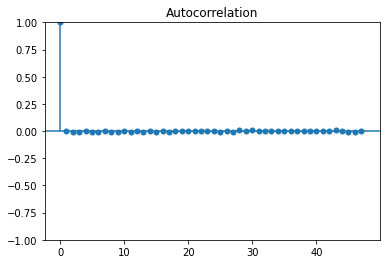

In [101]:
# Ploting the ACF on y_train
plot_acf(target.values)
plt.show()

In [100]:
# ADF test.
result = adfuller(target)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -130.1978350070247
p-value: 0.0
Critical Values:
	1%: -3.43048294385709
	5%: -2.861598758433234
	10%: -2.5668012751744005


/tmp/ipykernel_1884/4098552105.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=target.index.date, rotation=45)


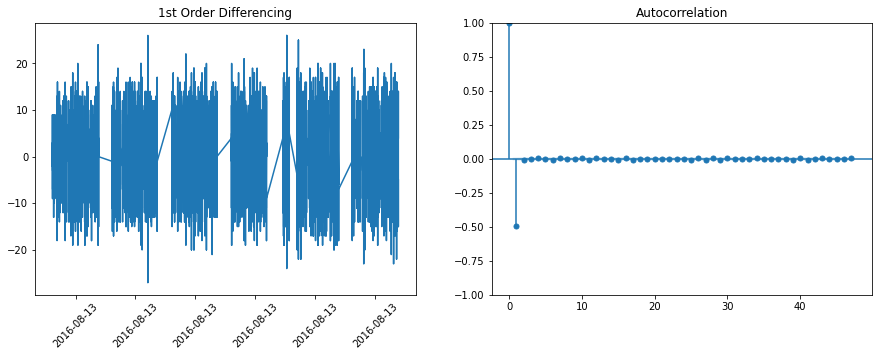

In [108]:
# Visualizing the 1st order Difference and the Autocorrelation side by side
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(target.diff())
ax1.set_xticklabels(labels=target.index.date, rotation=45)

ax2 = f.add_subplot(122)
plot_acf(target.diff().dropna(), ax=ax2)
plt.show()

As seen above, the first-order differencing looks good on the autocorrelation plot with a `d` value of 1 and a `q` value of 2.

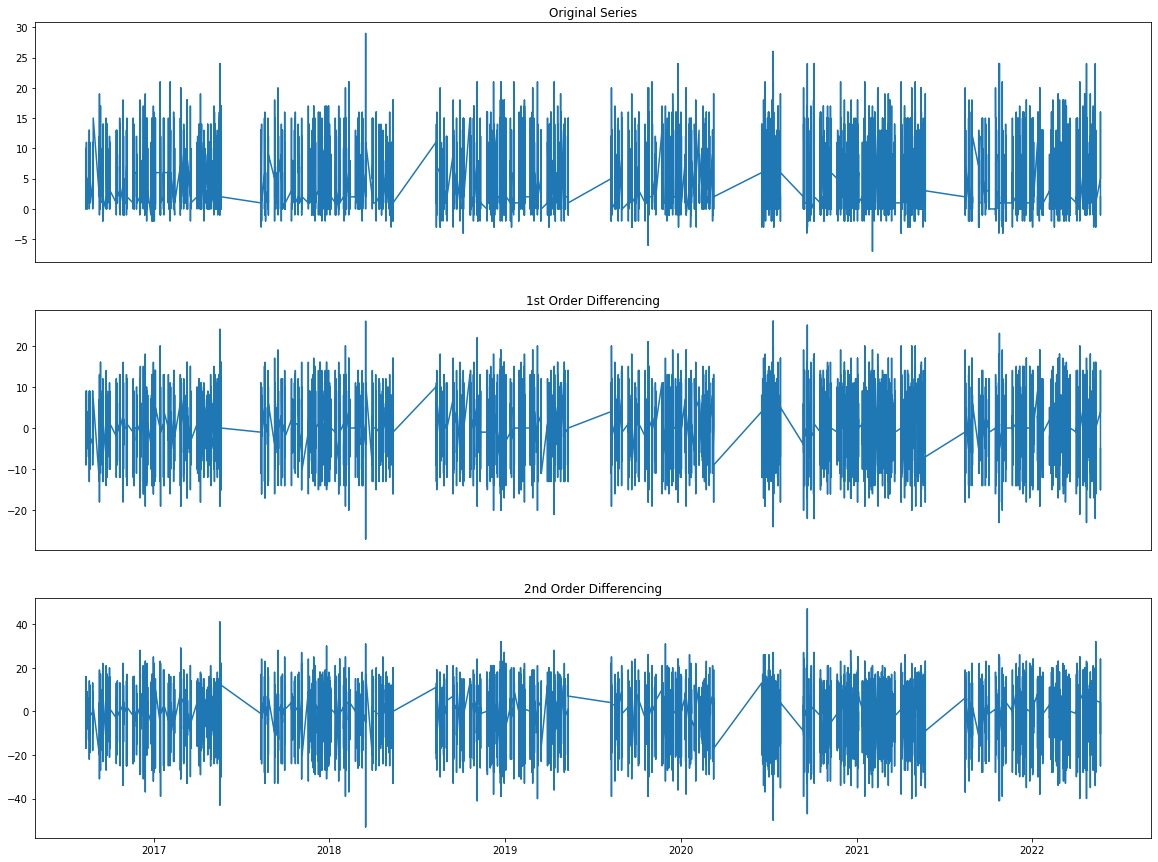

In [116]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (20, 15))
ax1.plot(target); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(target.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(target.diff().diff()); ax3.set_title('2nd Order Differencing');

/tmp/ipykernel_1884/1330558045.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels=target.index.date, rotation=45)


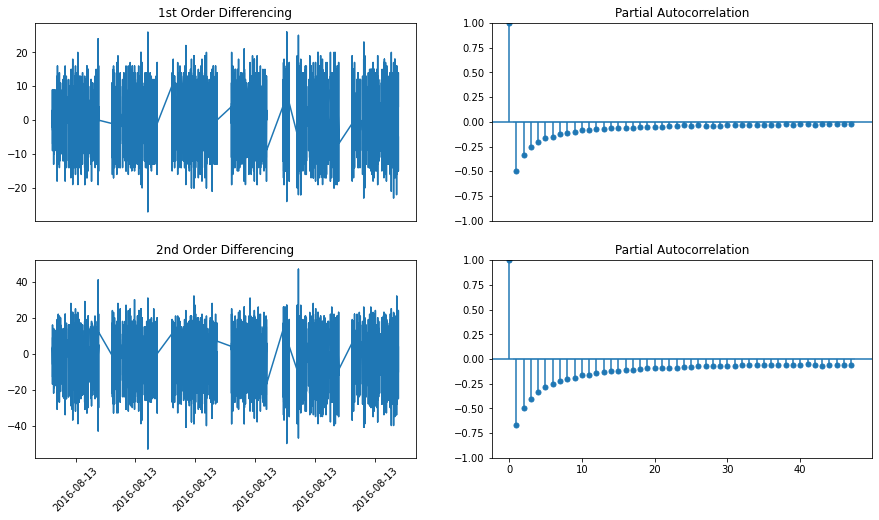

In [120]:
# Visualizing the 1st order Difference and the Autocorrelation side by side
f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(221)
ax1.set_title('1st Order Differencing')
ax1.plot(target.diff())
ax1.set_xticks(ticks=[]) # Let the 1st column share x ticks

ax2 = f.add_subplot(222)
plot_pacf(target.diff().dropna(), ax=ax2)
ax2.set_xticks(ticks=[]) # Let the 2nd column share x ticks

ax3 = f.add_subplot(223)
ax3.set_title('2nd Order Differencing')
ax3.plot(target.diff().diff())
ax3.set_xticklabels(labels=target.index.date, rotation=45)

ax4 = f.add_subplot(224)
plot_pacf(target.diff().diff().dropna(), ax=ax4)

plt.show()

As seen above, the first-order differencing looks good on the autocorrelation plot with a `p` value of 5.

Thus, the parameters for our ARIMA model are: 
`p` = 5, `d` = 1, and `q` = 2.

#### Fitting the ARIMA model

In [126]:
# Fitting the ARIMA model and printing the summary statistics
arima_model = ARIMA(target.values, order=(5,1,2))
model = arima_model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                49194
Model:                 ARIMA(5, 1, 2)   Log Likelihood             -124850.594
Date:                Fri, 16 Sep 2022   AIC                         249717.187
Time:                        10:54:46   BIC                         249787.615
Sample:                             0   HQIC                        249739.265
                              - 49194                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9672      0.043    -22.674      0.000      -1.051      -0.884
ar.L2         -0.0155      0.006     -2.499      0.012      -0.028      -0.003
ar.L3         -0.0213      0.006     -3.428      0.001      -0.033      -0.009
ar.L4         -0.0109      0.006     -1.736      0.083      -0.023       0.001
ar.L5         -0.0039      0.005     -0.865      0.387      -0.013       0.005
ma.L1         -0.0356      0.042     -0.838      0.402      -0.119       0.048
ma.L2         -0.9639      0.042    -22.697      0.000      -1.047      -0.881
sigma2         9.3739      0.039    242.392      0.000       9.298       9.450
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             61753.51
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
# Save ARIMA model.
with open('./model/arima_model.pkl', 'wb') as f_out4:
    pickle.dump(arima_model, f_out4)

In [134]:
x = model.forecast()
x

array([2.99119484])

<AxesSubplot:>

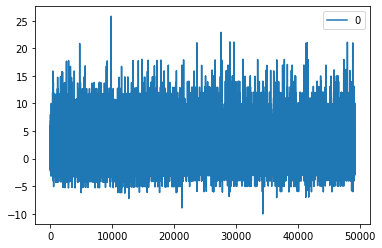

In [133]:
residuals = pd.DataFrame(model.resid)
residuals.plot()